# 📥 Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
# plt.style.use('ggplot')
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
import ipywidgets
from IPython.display import clear_output
import sympy as sp
import fitter
import numba as nb
import concurrent.futures

# 🎛️ Parameters

In [2]:
#==============================================================================
# Direct simulation parameters
#==============================================================================

# Wavelength
L = 1.65 * u.um

# Telescopes positions
TELESCOPE_POSITION = np.array([
    [0, 0],
    [1, 1],
    [2, 1.5],
    [3, 0.7],
]) * 42.2 * u.m

# Baseline rotation
ALPHA = 5 * u.deg

# Angular spearation
THETA = 2e-3 * u.arcsec

# Contrast
CONTRAST = 1e-3

# Kernel-Nuller parameters
INPUT_OPD_RMS = L/10
SHIFTS_OPD_RMS = L/10
SHIFTS_OPD_OFFSET = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) * L.unit
# SHIFTS_OPD_OFFSET = np.array([0.5, 1, 1.5, 0.25, 0.75, 0, 0.5, 1.25, 0.25, 1.5, 0, 1, 0.75, 1.25]) * u.um
# SHIFTS_OPD_OFFSET = np.array([1.65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) * L.unit

#==============================================================================
# Analysis parameters
#==============================================================================

# Baseline rotation range
ALPHA_RANGE = np.linspace(0, 360, 100) * u.deg

# Angular separation range
THETA_RANGE = np.linspace(0, 1e-2, 100) * u.arcsec

# Contrast range
CONTRAST_RANGE = np.logspace(-10, 0, 10)

In [3]:
# Parameters processing

# Enforce units (avoid to manage them all the time)
TELESCOPE_POSITION = TELESCOPE_POSITION.to(u.m)
ALPHA = ALPHA.to(u.rad)
THETA = THETA.to(u.rad)
INPUT_OPD_RMS = INPUT_OPD_RMS.to(L.unit)
SHIFTS_OPD_RMS = SHIFTS_OPD_RMS.to(L.unit)
SHIFTS_OPD_OFFSET = SHIFTS_OPD_OFFSET.to(L.unit)
ALPHA_RANGE = ALPHA_RANGE.to(u.rad)
THETA_RANGE = THETA_RANGE.to(u.rad)

# 📡 Telescope position

In [4]:
# Compute position telescope with rotated baseline

@nb.njit()
def rotate_baseline(telescope_positions:np.ndarray[float], alpha:float) -> np.ndarray[float]:
    """
    Rotate the telescope positions by an angle alpha.

    Parameters
    ----------
    - telescope_positions : Telescope positions.
    - alpha : Rotation angle in radians.

    Returns
    -------
    - np.ndarray[float] : Rotated telescope positions (same shape and unit as telescope_positions)
    """

    real_telescope_positions = np.empty_like(telescope_positions)
    for i in range(telescope_positions.shape[0]):
        x = telescope_positions[i][0]
        y = telescope_positions[i][1]
        a = alpha

        x2 = x * np.cos(a) - y * np.sin(a)
        y2 = x * np.sin(a) + y * np.cos(a)

        real_telescope_positions[i] = [x2, y2]
    return real_telescope_positions

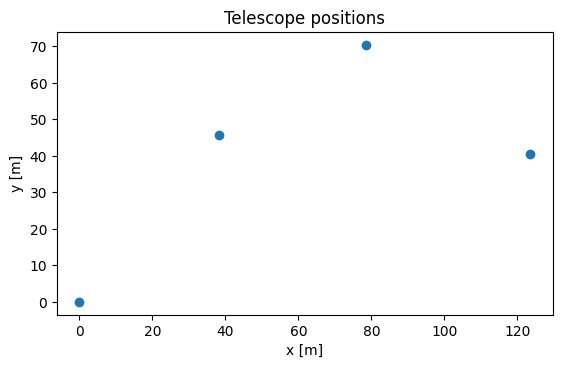

In [5]:
def plot_telescope_position():
    real_telescope_positions = rotate_baseline(TELESCOPE_POSITION.value, ALPHA.value) * TELESCOPE_POSITION.unit

    _, ax = plt.subplots()
    ax.scatter(real_telescope_positions[:, 0], real_telescope_positions[:, 1])
    ax.set_aspect('equal')
    ax.set_xlabel(f'x [{real_telescope_positions.unit}]')
    ax.set_ylabel(f'y [{real_telescope_positions.unit}]')
    ax.set_title('Telescope positions')
    plt.show()

plot_telescope_position()

# 🔧 Utils

In [6]:
# Bound OPD to [0, wavelenght[ in order to only consider phase shifts between 0 and 2pi
@nb.njit()
def bound_OPD(phase:float|np.ndarray[float], wavelenght:float) -> float|np.ndarray[float]:
    # return phase
    return wavelenght * np.mod(phase/wavelenght, 1)

# Numpy random.normal is not jit-able, so we need to define our own random.normal function
@nb.njit()
def random_normal(scale, size=1):
    return np.array([
            np.sqrt(-2*np.log(np.random.rand())) * np.cos(2*np.pi*np.random.rand()) * scale
        for _ in range(size)])

@nb.njit()
def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2)

In [7]:
# random_normal() validation
def plot_random_normal_histogram():
    plt.hist(random_normal(INPUT_OPD_RMS.value, size=1000000), bins=100, density=True)
    plt.plot(np.linspace(-1,1,100), gaussian(np.linspace(-1,1,100), 0, INPUT_OPD_RMS.value))
    plt.axvline(INPUT_OPD_RMS.value, linestyle='--', color='k')
    plt.axvline(-INPUT_OPD_RMS.value, linestyle='--', color='k')
    plt.axhline(gaussian(0, 0, INPUT_OPD_RMS.value)/2, linestyle='--', color='k')
    plt.show()
# plot_random_normal_histogram()

---

# 🎯 Goal

We aim to detect make direct detection of exoplanets. There is two main challenges to achieve this goal:
- The **contrast**: the exoplanet is much fainter than the star it orbits. The contrast is typically of the order of $10^{-6}$ to $10^{-10}$.
- The **angular separation**: the exoplanet is very close to the star. The angular separation depend on the distance of the exoplanet to the star and the distance of the star to the observer and can easily goes below the arcsecond.

# 🔎 Detection methods

It exist several methods to detect exoplanets. The most common are:
- **Radial velocity method**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the Doppler effect (the light is alternatively redshifted and blueshifted).
- **Transit method**: the exoplanet pass in front of the star and block a fraction of the light. This fraction can be detected by the decrease of the star luminosity.
- **Microlensing**: the exoplanet act as a lens and magnify the light of a background star. This magnification can be detected by the increase of the star luminosity.
- **Astrometry**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the change of the star position.
- **Coronography**: the exoplanet is directly imaged. This is the most challenging method because of the contrast and the angular separation.

<div align=center>
<img src="img/detection_methods.jpg" width=500px>
<p><i>Paul Anthony Wilson - Exoplanet detection techniques</i><p>
</div>

Until now, the coronography was the only method allowing direct detection. But it has two main limitations:
- It require huge telescopes in order to have a good angular resolution.
- The contrast we can achieve is limited by unperfect fabrication process of the optical components which lead to undesired diffraction effects.

# 🔆 Signal nature

The star and the planet are point sources. Seen from a classical telescope, it will result in an image made of the objects convolution with the point spread function (PSF) of the telescope.

$$
I = O \otimes PSF
$$

Here we consider the most simple PSF : the Airy disk. The Airy disk is the diffraction pattern of a point source by a circular aperture. It is given by:

$$
PSF = \left(\frac{2J_1(x)}{x}\right)^2
$$

where $J_1$ is the Bessel function of the first kind of order 1 and $x = \frac{2\pi r}{\lambda f}$ is the normalized radius of the Airy disk.

Then, we focus the image in a monomode optical fiber which will basically only keep the main lobe of the PSF and reshape it in a Gaussian form. In this process, we lose the spatial information so we have no longer images, but the light flux of each object in the fiber can be simply described by a complex number.

> I don't understand very well the physical process behing this injection in a monomode fiber. I need to dig into that.

Using this formalism, the light flux of the star and the planet can  be described by only 2 complex numbers for each telescope, giving the amplitude and phase of each object.

In [8]:
@nb.njit()
def acquire_signals(
    light: complex,
    angle: float,
    wavelenght: float,
    telescope_positions: np.ndarray[float],
    baseline_rotation: float,
) -> np.ndarray[complex]:
    """
    Acquire signals from the telescope positions.

    Parameters
    ----------
    - light : Light complexe amplitude.
    - angle : Baseline angle (in radians).
    - wavelenght : Wavelength (in meter).
    - telescope_positions : Telescope positions (in meter).
    - baseline_rotation : Baseline rotation angle (in radians).

    Returns
    -------
    - Acquired signals (complex amplitudes).
    """

    telescope_positions = rotate_baseline(telescope_positions, baseline_rotation)

    acquired_signals = np.empty(telescope_positions.shape[0], dtype=np.complex128)

    for i, p in enumerate(telescope_positions):
        introduced_phase = 2 * np.pi * p[0] * np.sin(angle) / wavelenght
        acquired_signals[i] = light * np.exp(1j * introduced_phase)
    return acquired_signals / np.sqrt(telescope_positions.shape[0])


def signals_as_str(signals: np.ndarray[complex]) -> str:
    """
    Convert signals to a string.

    Parameters
    ----------
    - signals : Signals to convert.

    Returns
    -------
    - String representation of the signals.
    """

    res = ""
    for i, s in enumerate(signals):
        res += f" - Telescope {i}:   {np.abs(s):.2e} *exp(i* {np.angle(s)/np.pi:.2f} *pi)   ->   {np.abs(s)**2:.2e}\n"
    return res[:-1]

In [9]:
STAR_LIGHT = 1+0j
PLANET_LIGHT = STAR_LIGHT * np.sqrt(CONTRAST)

STAR_SIGNALS = acquire_signals(STAR_LIGHT, 0, L.to(u.m).value, TELESCOPE_POSITION.value, ALPHA.value)
PLANET_SIGNALS = acquire_signals(PLANET_LIGHT, THETA.value, L.to(u.m).value, TELESCOPE_POSITION.value, ALPHA.value)

SHIFTS_TOTAL_OPD = bound_OPD(SHIFTS_OPD_OFFSET.value + random_normal(SHIFTS_OPD_RMS.value, size=14), L.value) * L.unit

IDEAL_SHIFTS = bound_OPD(-SHIFTS_TOTAL_OPD.value, L.value) * L.unit

print(f"Star signals:\n{signals_as_str(STAR_SIGNALS)}")
print(f"Planet signals:\n{signals_as_str(PLANET_SIGNALS)}")

Star signals:
 - Telescope 0:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
 - Telescope 1:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
 - Telescope 2:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
 - Telescope 3:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
Planet signals:
 - Telescope 0:   1.58e-02 *exp(i* 0.00 *pi)   ->   2.50e-04
 - Telescope 1:   1.58e-02 *exp(i* 0.45 *pi)   ->   2.50e-04
 - Telescope 2:   1.58e-02 *exp(i* 0.92 *pi)   ->   2.50e-04
 - Telescope 3:   1.58e-02 *exp(i* -0.55 *pi)   ->   2.50e-04


# ➖ Nulling

This is where the Nulling technic come into play. The idea is to use two several telescopes and take advantage of destructives interferances to cancel the star light and using the fact that the planet is not perfectly in the line of sight, which will lead to an unperfect destructive interference, or in best scenarios, on constructive ones! This is a very challenging technic because it is highly phase sensitive and require a very good control of the optical path.

<div align=center>
<img src="img/nulling_principle.jpg" width=400px>
</div>

In [10]:
@nb.njit()
def nuller_2x2(beams:np.ndarray[complex]) -> np.ndarray[complex]:
    """
    Simulate a 2 input beam nuller.

    Parameters
    ----------
    beams : ndarray[complex]
        Array of 2 input beams complex amplitudes

    Returns
    -------
    ndarray[complex]
        Array of 2 output beams complex amplitudes
            - 1st output is the bright channel
            - 2nd output is the dark channel
    """

    # # Input checks
    # try:
    #     beams = np.array(beams, dtype=np.complex128)
    # except:
    #     raise TypeError(f"'beams' must be an array-like object containing complex-convertible numbers, got {type(beams)}")
    # if beams.shape != (2,):
    #     raise ValueError(f"'beams' must have shape (2,), got {beams.shape}")

    # Nuller matrix
    N = 1/np.sqrt(2) * np.array([
        [1,   1],
        [1,  -1],
    ], dtype=np.complex128)

    # Operation
    return N @ beams

@nb.njit()
def nuller_4x4(beams:np.ndarray[complex]) -> np.ndarray[complex]:
    """
    Simulate a 4 input beam nuller.

    Parameters
    ----------
        Array of 4 input beams complex amplitudes

    Returns
    -------
    ndarray[complex]
        Array of 4 output beams complex amplitudes
            - 1st output is the bright channel
            - 2nd to 4th outputs are the dark channels
    """

    # # Input checks
    # try:
    #     beams = np.array(beams, dtype=np.complex128)
    # except:
    #     raise TypeError(f"'beams' must be an array-like object containing complex-convertible numbers, got {type(beams)}")
    # if beams.shape != (4,):
    #     raise ValueError(f"'beams' must have shape (4,), got {beams.shape}")

    # Dispatch the beams to the 2x2 nullers
    N1_output = nuller_2x2(beams[:2])
    N2_output = nuller_2x2(beams[2:])
    N3_output = nuller_2x2(np.array([N1_output[0], N2_output[0]]))
    N4_output = nuller_2x2(np.array([N1_output[1], N2_output[1]]))
                           
    return np.concatenate([N3_output, N4_output])

# 🏮 MMI

The nulling operation is made using Multi Mode Interferometer (MMI). It consist in a multimode waveguide taking several monomode fibers as input and output. The multimode waveguide is shaped in order to produce a specific interference operation, such as spreading the light of an input on all the output, or opposite, gathering the light of all the input on a single output.

To design a simple nuller, we then need a 2x2 MMI that gather (ie. create a constructive interference) all the input light on a single output. The other output is then a "nulled" output, where there is actually all the inputs light but in phase opposition, resulting in a destructive interference.

<div align=center>
<img src="img/mmi.png" width=400px>

*Numerical simulation of a 3x3 gathering MMI - Cvetojevic et. al.: 3-beam Kernel nuller (2022)*

</div>

# 🔀 Recombiner

The recombiner is also an MMI that will place the signals in phase quadrature. A particularity is that the output of the recombiner contain a symmetry. We will take advantage of this in the Kernel step.

<div align=center>
<img src="img/recombiner.png" width=500px>

*Action of a 2x2 recombiner MMI, taking 2 different combination of 4 nulled signals as input - Romain Laugier et al.: Kernel nullers for an arbitrary number of apertures (2020)*

</div>

In [11]:
@nb.njit()
def splitmix_2x2(beams:np.array, theta:float=np.pi/2) -> np.array:
    """
    Simulate a 2 input beam split and mix.

    Parameters
    ----------
    - `beams` : Array of 2 input beams complex amplitudes
    - `theta` : Phase shift between the two output beams

    Returns
    -------
    - Array of 2 output beams complex amplitudes
    """

    # # Input checks
    # try:
    #     beams = np.array(beams, dtype=np.complex128)
    # except:
    #     raise TypeError(f"'beams' must be an array-like object containing complex-convertible numbers, got {type(beams)}")
    # if beams.shape != (2,):
    #     raise ValueError(f"'beams' must have shape (2,), got {beams.shape}")

    # Splitter matrix
    S = 1/np.sqrt(2) * np.array([
        [np.exp(1j*theta/2), np.exp(-1j*theta/2)],
        [np.exp(-1j*theta/2), np.exp(1j*theta/2)]
    ])

    # Operation
    return S @ beams

@nb.njit()
def splitmix_3x6(beams:np.array, theta:float=np.pi/2) -> np.array:
    """
    Simulate a 4 input beam split and mix.

    Parameters
    ----------
    - `beams` : Array of 4 input beams complex amplitudes
    - `theta` : Phase shift between the two output beams

    Returns
    -------
    - Array of 6 output beams complex amplitudes
    """

    # # Input checks
    # try:
    #     beams = np.array(beams, dtype=np.complex128)
    # except:
    #     raise TypeError(f"'beams' must be an array-like object containing complex-convertible numbers, got {type(beams)}")
    # if beams.shape != (3,):
    #     raise ValueError(f"'beams' must have shape (3,), got {beams.shape}")

    # Dispatch the beams over the 3 split&mix
    S1_output = splitmix_2x2([beams[0], beams[1]])
    S2_output = splitmix_2x2([beams[0], beams[2]])
    S3_output = splitmix_2x2([beams[1], beams[2]])

    return np.concatenate([S1_output, S2_output, S3_output])

# 💠 Kernel

The idea of the kernel is to acquire and substract the pairs of recombined output. As these pairs share symmetrical properties, this substraction will cancel the star light even with first order phase aberations while keeping the planet light!

Moreover, it modify the nuller response (see transmission maps below) in an asymetric way which is interesting for us as it gives us more information to constrain the planet position.

Demonstration:

In [12]:
# Elements definition
I = sp.IndexedBase('I', real=True) # Kernel intensity
E = sp.IndexedBase('E') # Electric field
A = sp.IndexedBase('A', real=True) # Amplitude
P = sp.IndexedBase('phi', real=True) # Relative phase
T = sp.IndexedBase('theta', real=True) # Phase perturbation
a = sp.symbols('a', cls=sp.Idx) # First dark
b = sp.symbols('b', cls=sp.Idx) # Second dark
s = sp.symbols('s', cls=sp.Idx) # Star index
p = sp.symbols('p', cls=sp.Idx) # Planet index

In [13]:
# Intensity in a dark output is the sum of the intensities coming from the star and from the planet
Ia = I[a,s] + I[a,p]
Ib = I[b,s] + I[b,p]
Ia

I[a, p] + I[a, s]

In [14]:
# Developping Intensities as interference of the electrical fields
Ias = abs(E[1,s] + E[2,s] + E[3,s] + E[4,s])**2
Iap = abs(E[1,p] + E[2,p] + E[3,p] + E[4,p])**2
Ibs = abs(E[1,s] + E[2,s] + E[3,s] + E[4,s])**2
Ibp = abs(E[1,p] + E[2,p] + E[3,p] + E[4,p])**2

Ia = Ia.subs(I[a,s], Ias).subs(I[a,p], Iap)
Ib = Ia.subs(I[b,s], Ibs).subs(I[b,p], Ibp)
Ia

Abs(E[1, p] + E[2, p] + E[3, p] + E[4, p])**2 + Abs(E[1, s] + E[2, s] + E[3, s] + E[4, s])**2

In [15]:
# Expressing the electric fields as a function of the amplitudes and the relative phases
E1s = A[s]
E2s = A[s] * (1 + sp.I * T[2])
E3s = A[s] * (1 + sp.I * T[3])
E4s = A[s] * (1 + sp.I * T[4])
E1p = A[p] * sp.exp(sp.I * P[1])
E2p = A[p] * sp.exp(sp.I * P[2]) * (1 + sp.I * T[2])
E3p = A[p] * sp.exp(sp.I * P[3]) * (1 + sp.I * T[3])
E4p = A[p] * sp.exp(sp.I * P[4]) * (1 + sp.I * T[4])

# Relative phase : E1 -> 0, E2 -> pi, E3 -> pi/2, E4 -> -pi/2
Ia = Ia.subs(E[1,s], E1s).subs(E[2,s], -E2s).subs(E[3,s], sp.I*E3s).subs(E[4,s], -sp.I*E4s)
Ia = Ia.subs(E[1,p], E1p).subs(E[2,p], -E2p).subs(E[3,p], sp.I*E3p).subs(E[4,p], -sp.I*E4p)
# Relative phase : E1 -> 0, E2 -> pi, E3 -> -pi/2, E4 -> pi/2
Ib = Ib.subs(E[1,p], E1p).subs(E[2,p], -E2p).subs(E[3,p], -sp.I*E3p).subs(E[4,p], sp.I*E4p)
Ib = Ib.subs(E[1,s], E1s).subs(E[2,s], -E2s).subs(E[3,s], -sp.I*E3s).subs(E[4,s], sp.I*E4s)
Ia.expand().simplify()

((-I*exp(I*phi[2])*theta[2] - exp(I*phi[2]) - exp(I*phi[3])*theta[3] + I*exp(I*phi[3]) + exp(I*phi[4])*theta[4] - I*exp(I*phi[4]))*exp(I*(phi[2] + phi[3] + phi[4]))*A[p]**2 + (A[p]**2*theta[2]**2 + A[p]**2*theta[3]**2 + A[p]**2*theta[4]**2 + 4*A[p]**2 + A[s]**2*theta[2]**2 + A[s]**2*theta[3]**2 - 2*A[s]**2*theta[3]*theta[4] + A[s]**2*theta[4]**2)*exp(I*(phi[1] + phi[2] + phi[3] + phi[4])) + (-exp(I*phi[1])*theta[3] - I*exp(I*phi[1]) + I*exp(I*phi[2])*theta[2]*theta[3] - exp(I*phi[2])*theta[2] + exp(I*phi[2])*theta[3] + I*exp(I*phi[2]) - exp(I*phi[4])*theta[3]*theta[4] + I*exp(I*phi[4])*theta[3] - I*exp(I*phi[4])*theta[4] - exp(I*phi[4]))*exp(I*(phi[1] + phi[2] + phi[4]))*A[p]**2 + (exp(I*phi[1])*theta[4] + I*exp(I*phi[1]) - I*exp(I*phi[2])*theta[2]*theta[4] + exp(I*phi[2])*theta[2] - exp(I*phi[2])*theta[4] - I*exp(I*phi[2]) - exp(I*phi[3])*theta[3]*theta[4] - I*exp(I*phi[3])*theta[3] + I*exp(I*phi[3])*theta[4] - exp(I*phi[3]))*exp(I*(phi[1] + phi[2] + phi[3]))*A[p]**2 + (I*exp(I*phi[1]

In [16]:
Ik = Ia - Ib
Ik.expand().simplify()

2*((-exp(I*phi[3])*theta[3] + I*exp(I*phi[3]) + exp(I*phi[4])*theta[4] - I*exp(I*phi[4]))*exp(I*(phi[2] + phi[3] + phi[4])) + (-exp(I*phi[1])*theta[3] - I*exp(I*phi[1]) + I*exp(I*phi[2])*theta[2]*theta[3] - exp(I*phi[2])*theta[2] + exp(I*phi[2])*theta[3] + I*exp(I*phi[2]))*exp(I*(phi[1] + phi[2] + phi[4])) + (exp(I*phi[1])*theta[4] + I*exp(I*phi[1]) - I*exp(I*phi[2])*theta[2]*theta[4] + exp(I*phi[2])*theta[2] - exp(I*phi[2])*theta[4] - I*exp(I*phi[2]))*exp(I*(phi[1] + phi[2] + phi[3])) + (-I*exp(I*phi[3])*theta[2]*theta[3] - exp(I*phi[3])*theta[2] + exp(I*phi[3])*theta[3] - I*exp(I*phi[3]) + I*exp(I*phi[4])*theta[2]*theta[4] + exp(I*phi[4])*theta[2] - exp(I*phi[4])*theta[4] + I*exp(I*phi[4]))*exp(I*(phi[1] + phi[3] + phi[4])))*exp(-I*(phi[1] + phi[2] + phi[3] + phi[4]))*A[p]**2

# 🌡️ Thermo-optic phase shifter

In practice, we are often limited by the fabrication process of the optical components. The imperfections can lead into phase aberations that will degrade the Kernel-Nuller performance. An attempt to correct these aberations consist in using thermo-optic phase shifters. It consist in a waveguide with a heater that will modify the refractive index of the waveguide and thus the phase of the light passing through it.

As the size of the waveguide is very small, the thermal inertia is very low and the phase can be modified very quickly, in a milisecond time scale. This is a very interesting solution to correct phase aberations, even in real time if we encounter variable phase aberation sources.

<div align=center>
<img src="img/thermo-optic_phase_shifter.png" width=500px>
</div>

In [17]:
@nb.njit()
def phase_shift(beam:complex, OPD:float, wavelenght) -> complex:
    """------------------------------------------------------------------------
    De-phase the input beam by heating the fiber with an electrical current.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `OPD` : Optical Path Difference
    - `wavelenght` : Wavelength (same unit as OPD)
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""
    return beam * np.exp(1j * 2*np.pi * OPD / wavelenght)

# 🏗️ Current architecture

To implement the 4 telescop tunable Kernel-Nuller, we splitted the 4x4 MMI into series of 2x2 MMI separated by phase shifters.

<div align=center>
<img src="img/scheme.png" width=1000px>

*Architecture of our Kernel-Nuller. N suqares are the 2x2 nullers, S squares are the 2x2 recombiners and P rectangles are the phase shifters*

</div>

In [18]:
@nb.njit()
def kn(beams:np.ndarray[complex], shifts:np.ndarray[float], shifts_total_OPD:np.ndarray[float], wavelenght:float) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], float]:
    """
    Simulate a 4 telescope Kernel-Nuller propagation using a numeric approach

    Parameters
    ----------
    beams : np.ndarray[complex]
        Array of 4 input beams complex amplitudes
    shifts : np.ndarray[complex]
        Array of 14 phase shifts

    Returns
    -------
    ndarray[float]
        Array of 3 null outputs intensities
    ndarray[float]
        Array of 6 dark outputs intensities
    ndarray[float]
        Array of 3 kernels intensities
    float
        Bright output intensity
    """

    shifts = bound_OPD(shifts + shifts_total_OPD, wavelenght)

    # First layer of pahse shifters
    nuller_inputs = phase_shift(beams, shifts[:4], wavelenght)

    # First layer of nulling
    N1 = nuller_2x2(nuller_inputs[:2])
    N2 = nuller_2x2(nuller_inputs[2:])

    # Second layer of phase shifters
    N1_shifted = phase_shift(N1, shifts[4:6], wavelenght)
    N2_shifted = phase_shift(N2, shifts[6:8], wavelenght)

    # Second layer of nulling
    N3 = nuller_2x2(np.array([N1_shifted[0], N2_shifted[0]]))
    N4 = nuller_2x2(np.array([N1_shifted[1], N2_shifted[1]]))

    nulls = np.array([N3[1], N4[0], N4[1]], dtype=np.complex128)
    bright = N3[0]

    # Beam splitting
    S_inputs = np.array([
        N3[1],
        N3[1],
        N4[0],
        N4[0],
        N4[1],
        N4[1]
    ]) * 1/np.sqrt(2)

    # Last layer of phase shifters
    S_inputs = phase_shift(S_inputs, shifts[8:], wavelenght)

    # Beam mixing
    S1_output = splitmix_2x2(np.array([S_inputs[0],S_inputs[2]]))
    S2_output = splitmix_2x2(np.array([S_inputs[1],S_inputs[4]]))
    S3_output = splitmix_2x2(np.array([S_inputs[3],S_inputs[5]]))

    darks = np.array([
        S1_output[0],
        S1_output[1],
        S2_output[0],
        S2_output[1],
        S3_output[0],
        S3_output[1]
    ], dtype=np.complex128)

    kernels = np.array([np.abs(darks[2*i])**2 - np.abs(darks[2*i+1])**2 for i in range(3)])

    return nulls, darks, kernels, bright

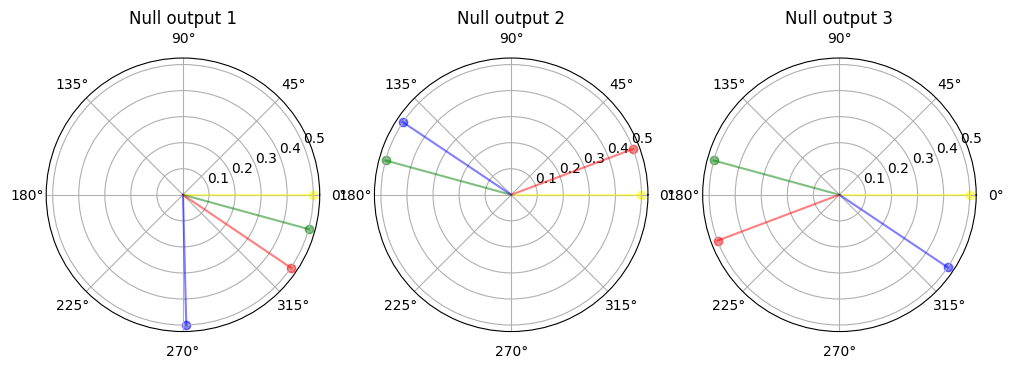

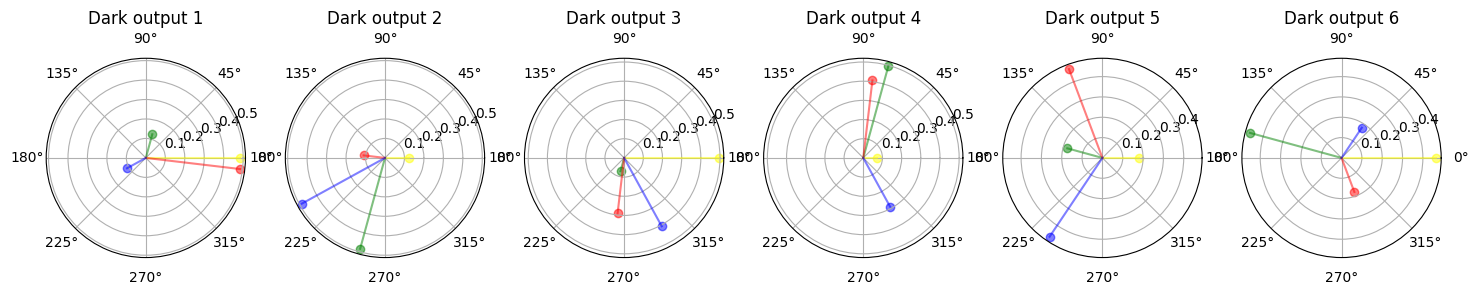

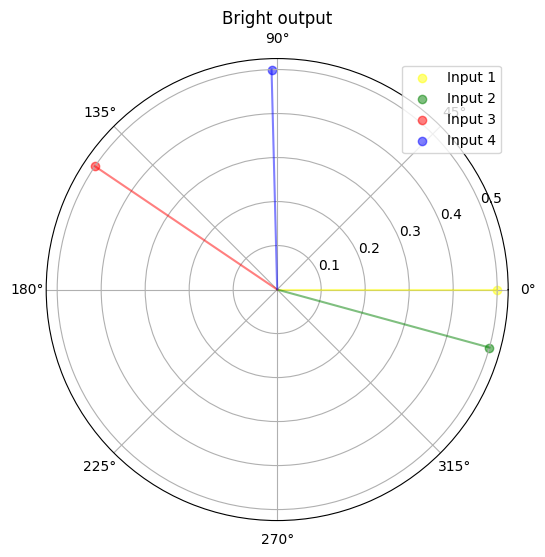

In [19]:
def plot_kn_phase_effect(shifts=None):

    if shifts is None:
        shifts = np.zeros(14) * L.unit

    input1_signal = np.array([1+0j, 0, 0, 0])
    input2_signal = np.array([0, 1+0j, 0, 0])
    input3_signal = np.array([0, 0, 1+0j, 0])
    input4_signal = np.array([0, 0, 0, 1+0j])

    nulls1, darks1, _, bright1 = kn(input1_signal, shifts.value, SHIFTS_TOTAL_OPD.value, wavelenght=L.value)
    nulls2, darks2, _, bright2 = kn(input2_signal, shifts.value, SHIFTS_TOTAL_OPD.value, wavelenght=L.value)
    nulls3, darks3, _, bright3 = kn(input3_signal, shifts.value, SHIFTS_TOTAL_OPD.value, wavelenght=L.value)
    nulls4, darks4, _, bright4 = kn(input4_signal, shifts.value, SHIFTS_TOTAL_OPD.value, wavelenght=L.value)

    # Using first signal as reference
    nulls2 = np.abs(nulls2) * np.exp(1j * (np.angle(nulls2) - np.angle(nulls1)))
    nulls3 = np.abs(nulls3) * np.exp(1j * (np.angle(nulls3) - np.angle(nulls1)))
    nulls4 = np.abs(nulls4) * np.exp(1j * (np.angle(nulls4) - np.angle(nulls1)))
    darks2 = np.abs(darks2) * np.exp(1j * (np.angle(darks2) - np.angle(darks1)))
    darks3 = np.abs(darks3) * np.exp(1j * (np.angle(darks3) - np.angle(darks1)))
    darks4 = np.abs(darks4) * np.exp(1j * (np.angle(darks4) - np.angle(darks1)))
    bright2 = np.abs(bright2) * np.exp(1j * (np.angle(bright2) - np.angle(bright1)))
    bright3 = np.abs(bright3) * np.exp(1j * (np.angle(bright3) - np.angle(bright1)))
    bright4 = np.abs(bright4) * np.exp(1j * (np.angle(bright4) - np.angle(bright1)))
    nulls1 = np.abs(nulls1) * np.exp(1j * 0)
    darks1 = np.abs(darks1) * np.exp(1j * 0)
    bright1 = np.abs(bright1) * np.exp(1j * 0)




    # Null outputs
    _, axs = plt.subplots(1, 3, figsize=(12, 12), subplot_kw={'projection': 'polar'})
    for null in range(3):
        axs[null].scatter(np.angle(nulls1[null]), np.abs(nulls1[null]), color="yellow", label='Input 1', alpha=0.5)
        axs[null].plot([0, np.angle(nulls1[null])], [0, np.abs(nulls1[null])], color="yellow", alpha=0.5)
        axs[null].scatter(np.angle(nulls2[null]), np.abs(nulls2[null]), color="green", label='Input 2', alpha=0.5)
        axs[null].plot([0, np.angle(nulls2[null])], [0, np.abs(nulls2[null])], color="green", alpha=0.5)
        axs[null].scatter(np.angle(nulls3[null]), np.abs(nulls3[null]), color="red", label='Input 3', alpha=0.5)
        axs[null].plot([0, np.angle(nulls3[null])], [0, np.abs(nulls3[null])], color="red", alpha=0.5)
        axs[null].scatter(np.angle(nulls4[null]), np.abs(nulls4[null]), color="blue", label='Input 4', alpha=0.5)
        axs[null].plot([0, np.angle(nulls4[null])], [0, np.abs(nulls4[null])], color="blue", alpha=0.5)
        axs[null].set_title(f'Null output {null+1}')

    # Dark outputs
    _, axs = plt.subplots(1, 6, figsize=(18, 12), subplot_kw={'projection': 'polar'})
    for dark in range(6):
        axs[dark].scatter(np.angle(darks1[dark]), np.abs(darks1[dark]), color="yellow", label='Input 1', alpha=0.5)
        axs[dark].plot([0, np.angle(darks1[dark])], [0, np.abs(darks1[dark])], color="yellow", alpha=0.5)
        axs[dark].scatter(np.angle(darks2[dark]), np.abs(darks2[dark]), color="green", label='Input 2', alpha=0.5)
        axs[dark].plot([0, np.angle(darks2[dark])], [0, np.abs(darks2[dark])], color="green", alpha=0.5)
        axs[dark].scatter(np.angle(darks3[dark]), np.abs(darks3[dark]), color="red", label='Input 3', alpha=0.5)
        axs[dark].plot([0, np.angle(darks3[dark])], [0, np.abs(darks3[dark])], color="red", alpha=0.5)
        axs[dark].scatter(np.angle(darks4[dark]), np.abs(darks4[dark]), color="blue", label='Input 4', alpha=0.5)
        axs[dark].plot([0, np.angle(darks4[dark])], [0, np.abs(darks4[dark])], color="blue", alpha=0.5)
        axs[dark].set_title(f'Dark output {dark+1}')

    # Bright output
    _, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': 'polar'})
    ax.scatter(np.angle(bright1), np.abs(bright1), color="yellow", label='Input 1', alpha=0.5)
    ax.plot([0, np.angle(bright1)], [0, np.abs(bright1)], color="yellow", alpha=0.5)
    ax.scatter(np.angle(bright2), np.abs(bright2), color="green", label='Input 2', alpha=0.5)
    ax.plot([0, np.angle(bright2)], [0, np.abs(bright2)], color="green", alpha=0.5)
    ax.scatter(np.angle(bright3), np.abs(bright3), color="red", label='Input 3', alpha=0.5)
    ax.plot([0, np.angle(bright3)], [0, np.abs(bright3)], color="red", alpha=0.5)
    ax.scatter(np.angle(bright4), np.abs(bright4), color="blue", label='Input 4', alpha=0.5)
    ax.plot([0, np.angle(bright4)], [0, np.abs(bright4)], color="blue", alpha=0.5)
    ax.set_title('Bright output')
    ax.legend()

plot_kn_phase_effect()

# 🗺️ Transmission maps

The nulling technic with two telescope show a limitation: if the planet light arrive on the two telescopes with a phase shift of $2n\pi$, the light will also be cancelled. It result in a comb-shaped transmission map, perpendicular to the baseline (there is clear bands where it's optimal to detect the planet and black bands where we will mostly destroy the planet light).

The idea of Bracewell was to rotate the baseline in order to let the planet pass through the clear bands at some point. After an entire rotation of the baseline, we will have a sinusoidal signal from which the frequency will indicate us the distance of the planet to it's star, and the phase will give us a clue about the angle between the axes star-planet and the axes of the baseline. Thus, as the transmission map is symmetric, we can constrain the planet position to 2 possible locations, on both sides of the star.

Here, we are using 4 telescopes, resulting in more complexe transmission maps than simple combs, but the principle is the same.

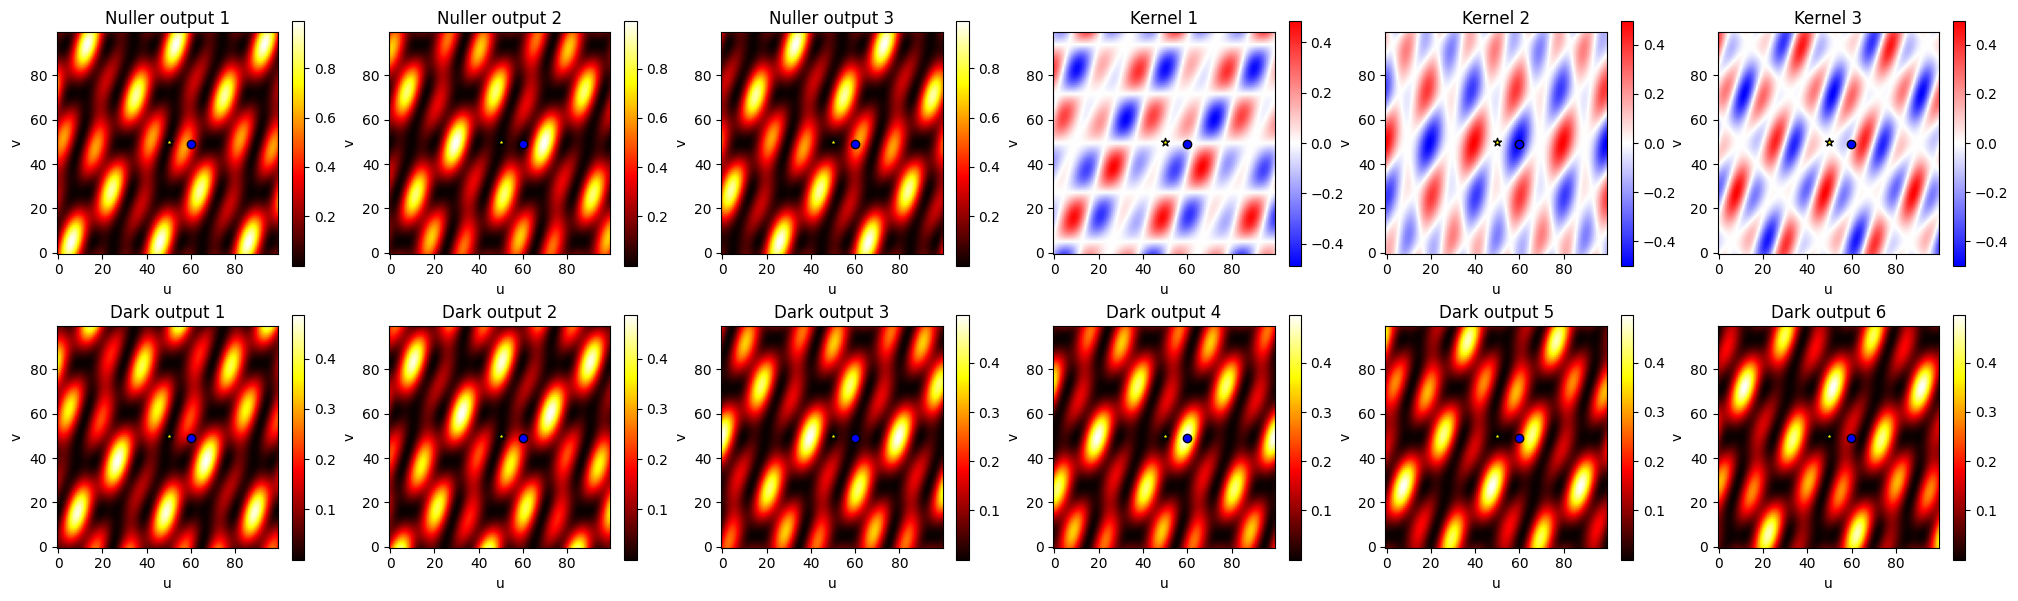

Planet intensity in input:          2.50e-04 | 2.50e-04 | 2.50e-04 | 2.50e-04
Planet intensity on null outputs:   5.12e-04 | 3.61e-06 | 4.80e-04
Planet intensity on dark outputs:   1.45e-04 | 1.13e-04 | 1.35e-07 | 4.96e-04 | 1.07e-04 | 1.35e-04
Planet intensity on kernel outputs: 3.12e-05 | -4.96e-04 | -2.84e-05
Planet intensity on bright output:  3.60e-06


In [20]:
def plot_transmission_maps():
    global theta, alpha

    resolution = 100

    nuller_transmission_maps = np.zeros((3, resolution, resolution), dtype=np.complex128)
    dark_transmission_maps = np.zeros((6, resolution, resolution), dtype=np.complex128)
    kernel_transmission_maps = np.zeros((3, resolution, resolution), dtype=float)

    X, Y = np.meshgrid(np.linspace(-1, 1, resolution), np.linspace(-1, 1, resolution))
    theta_map = (THETA_RANGE[0] + np.sqrt(X**2 + Y**2) * (THETA_RANGE[-1] - THETA_RANGE[0]))
    alpha_range = np.arctan2(Y, X) * u.rad

    for x in range(resolution):
        for y in range(resolution):
            new_theta = theta_map[x, y]
            new_alpha = alpha_range[x, y]
            signals = acquire_signals(STAR_LIGHT, new_theta.value, L.to(u.m).value, TELESCOPE_POSITION.value, new_alpha.value)

            nulls, darks, kernels, bright = kn(signals, shifts=np.zeros(14), shifts_total_OPD=np.zeros(14), wavelenght=L.value)

            for i in range(3):
                nuller_transmission_maps[i, x, y] = nulls[i]
            
            for i in range(6):
                dark_transmission_maps[i, x, y] = darks[i]

            for i in range(3):
                kernel_transmission_maps[i, x, y] = kernels[i]
    
    normalized_theta = (THETA - THETA_RANGE[0]) / (THETA_RANGE[-1] - THETA_RANGE[0])
    theta_as_x = (normalized_theta*np.cos(-ALPHA)/2+0.5)*resolution
    theta_as_y = (normalized_theta*np.sin(-ALPHA)/2+0.5)*resolution

    _, axs = plt.subplots(2, 6, figsize=(25, 7))
    
    for i in range(3):
        im = axs[0,i].imshow(np.abs(nuller_transmission_maps[i])**2, aspect='equal', cmap="hot")
        axs[0,i].set_title(f"Nuller output {i+1}")
        axs[0,i].set_xlabel('u')
        axs[0,i].set_ylabel('v')
        plt.colorbar(im, ax=axs[0,i])
        axs[0,i].scatter(0.5*resolution, 0.5*resolution, color='yellow', marker="*", edgecolors='black')
        axs[0,i].scatter(theta_as_x, theta_as_y, color='blue', edgecolors='black')

    for i in range(6):
        im = axs[1,i].imshow(np.abs(dark_transmission_maps[i])**2, aspect='equal', cmap="hot")
        axs[1,i].set_title(f"Dark output {i+1}")
        axs[1,i].set_xlabel('u')
        axs[1,i].set_ylabel('v')
        axs[1,i].set_aspect('equal')
        plt.colorbar(im, ax=axs[1,i])
        axs[1,i].scatter(0.5*resolution, 0.5*resolution, color='yellow', marker="*", edgecolors='black')
        axs[1,i].scatter(theta_as_x, theta_as_y, color='blue', edgecolors='black')

    for i in range(3):
        im = axs[0,i+3].imshow(kernel_transmission_maps[i], aspect='equal', cmap="bwr")
        axs[0,i+3].set_title(f"Kernel {i+1}")
        axs[0,i+3].set_xlabel('u')
        axs[0,i+3].set_ylabel('v')
        plt.colorbar(im, ax=axs[0,i+3])
        axs[0,i+3].scatter(0.5*resolution, 0.5*resolution, color='yellow', marker="*", edgecolors='black')
        axs[0,i+3].scatter(theta_as_x, theta_as_y, color='blue', edgecolors='black')

    plt.show()

    signals = acquire_signals(PLANET_LIGHT, THETA.value, L.to(u.m).value, TELESCOPE_POSITION.value, ALPHA)
    nulls, darks, kernels, bright = kn(signals, shifts=np.zeros(14), shifts_total_OPD=np.zeros(14), wavelenght=L.value) 
    print(f"Planet intensity in input:          {' | '.join([f'{np.abs(i)**2:.2e}' for i in PLANET_SIGNALS])}")
    print(f"Planet intensity on null outputs:   {' | '.join([f'{np.abs(n)**2:.2e}' for n in nulls])}")
    print(f"Planet intensity on dark outputs:   {' | '.join([f'{np.abs(d)**2:.2e}' for d in darks])}")
    print(f"Planet intensity on kernel outputs: {' | '.join([f'{k:.2e}' for k in kernels])}")
    print(f"Planet intensity on bright output:  {np.abs(bright)**2:.2e}")

plot_transmission_maps()

# 🫳 Manual shift controls

In [21]:
step = 1e-20

# Build sliders
P_sliders = [widgets.FloatSlider(value=0, min=0, max=L.value, step=step, description=f"P{i+1}") for i in range(14)]

nulls, darks, kernels, bright = kn(STAR_SIGNALS, np.array([x.value for x in P_sliders]), SHIFTS_TOTAL_OPD.value, L.value)

def beam_repr(beam:complex) -> str:
    return f"{np.abs(beam):.3e} * exp({np.angle(beam)/np.pi:.2f} pi i)"   

inputs = [widgets.Label(value=f" ") for _ in range(4)]
null_outputs = [widgets.Label(value=f" ") for _ in range(4)]
dark_outputs = [widgets.Label(value=f" ") for _ in range(6)]

def update_gui(*args):

    nulls, darks, kernels, bright = kn(STAR_SIGNALS, np.array([x.value for x in P_sliders]), SHIFTS_TOTAL_OPD.value, L.value)

    for i, beam in enumerate(STAR_SIGNALS):
        inputs[i].value = f"Input {i+1}: {beam_repr(beam)} | Intensity: {np.abs(beam)**2:.2e}"

    
    null_outputs[0].value = f"N3a: {beam_repr(bright)} | Intensity: {np.abs(bright)**2:.2e} <- Bright channel"
    for i, beam in enumerate(nulls):
        null_outputs[i+1].value = f"N{i//2+3}{['a','b'][(i+1)%2]}: {beam_repr(beam)} | Intensity: {np.abs(beam)**2:.2e}"

    for i, beam in enumerate(darks): 
        dark_outputs[i].value = f"Dark {i+1}: {beam_repr(beam)} | Intensity: {np.abs(beam)**2:.2e}"

    return bright, darks

for widget in P_sliders:
    widget.observe(update_gui, 'value')

empty = widgets.Label()

vbox = widgets.VBox([
    *[widgets.HBox([x]) for x in inputs],

    widgets.Label("Nuller shifters"),
    widgets.HBox(P_sliders[:4]),
    widgets.HBox(P_sliders[4:8]),
    
    *[widgets.HBox([x]) for x in null_outputs],

    widgets.Label("Recombiner shifters"),
    widgets.HBox(P_sliders[8:11]),
    widgets.HBox(P_sliders[11:14]),

    *[widgets.HBox([x]) for x in dark_outputs],
])

update_gui()
vbox

# 📉 Optimization process

In [22]:
def optimize(kn, beams, shifts_total_OPD, wavelenght, input_OPD_rms, verbose=False):
    """--------------------------------------------------------------------
    Optimize the phase shifters offsets to maximize the nulling performance
    
    Parameters
    ----------
    - `kn` : Kernel-Nuller object
    - `beams` : List of input beams complex amplitudes
    - `verbose` : Boolean, if True, print the optimization process

    Returns
    -------
    - List of optimized phase shifters offsets
    - Dict containing the history of the optimization
    --------------------------------------------------------------------"""

    shifts = np.zeros(14)

    treshold = 1e-20
    decay = 1.1 # Decay factor for the step size (delta /= decay)

    # Shifters that contribute to redirecting light to the bright output
    # p1 = [2,3,4,5,7] # 1,
    p1 = [1,2,3,4,5,7]

    # Shifters that contribute to the symmetry of the dark outputs
    # p2 = [6,8,11,13,14] # 9,10,12,
    p2 = [6,8,11,13,14,9,10,12]

    bright_history = []
    symmetry_history = []
    shifters_history = []

    delta = wavelenght / 2
    while delta > treshold:        
        for p in p1 + p2:
            step = np.zeros(14)
            step[p-1] = delta

            _, _, kernels_old, bright_old = kn(beams, shifts, shifts_total_OPD, wavelenght)
            _, _, kernels_pos, bright_pos = kn(beams, shifts+step, shifts_total_OPD, wavelenght)
            _, _, kernels_neg, bright_neg = kn(beams, shifts-step, shifts_total_OPD, wavelenght)

            metric_old = np.sum(np.abs(kernels_old))
            metric_pos = np.sum(np.abs(kernels_pos))
            metric_neg = np.sum(np.abs(kernels_neg))

            bright_history.append(abs(bright_old)**2)
            symmetry_history.append(metric_old)
            shifters_history.append(np.copy(shifts))

            if p in p1:
                if abs(bright_pos) > abs(bright_old) and abs(bright_pos) > abs(bright_neg):
                    shifts += step
                elif abs(bright_neg) > abs(bright_old) and abs(bright_neg) > abs(bright_pos):
                    shifts -= step
            else:
                if metric_pos < metric_old and metric_pos < metric_neg:
                    shifts += step
                elif metric_neg < metric_old and metric_neg < metric_pos:
                    shifts -= step

        delta /= decay

    return shifts, {"bright":np.array(bright_history), "symmetry":np.array(symmetry_history), "shifters":np.array(shifters_history)}

optimized_shifts, history = optimize(kn, STAR_SIGNALS, SHIFTS_TOTAL_OPD.value, L.value, INPUT_OPD_RMS.value, verbose=False)
optimized_shifts = bound_OPD(optimized_shifts, L.value) * L.unit

OPTIMIZED_SHIFTS = optimized_shifts.copy()

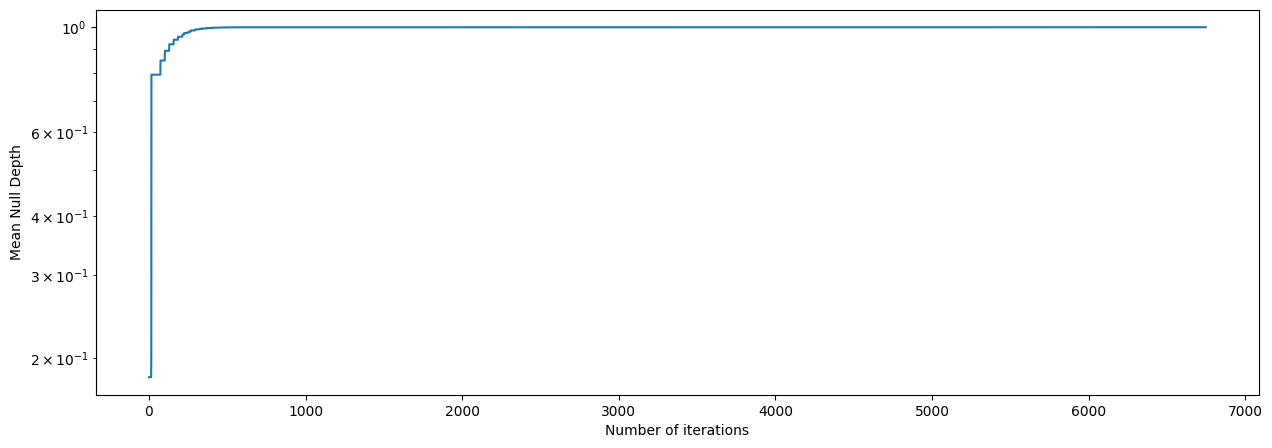

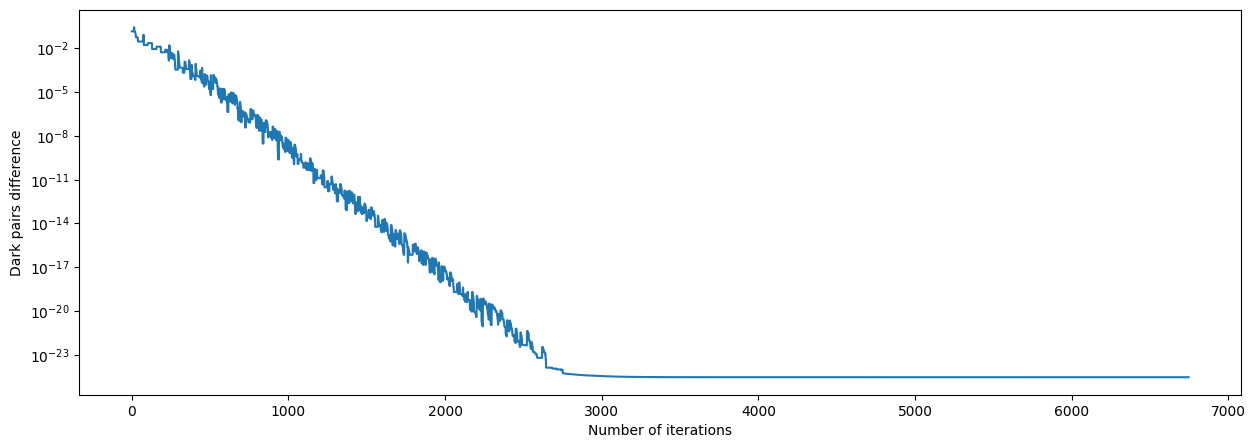

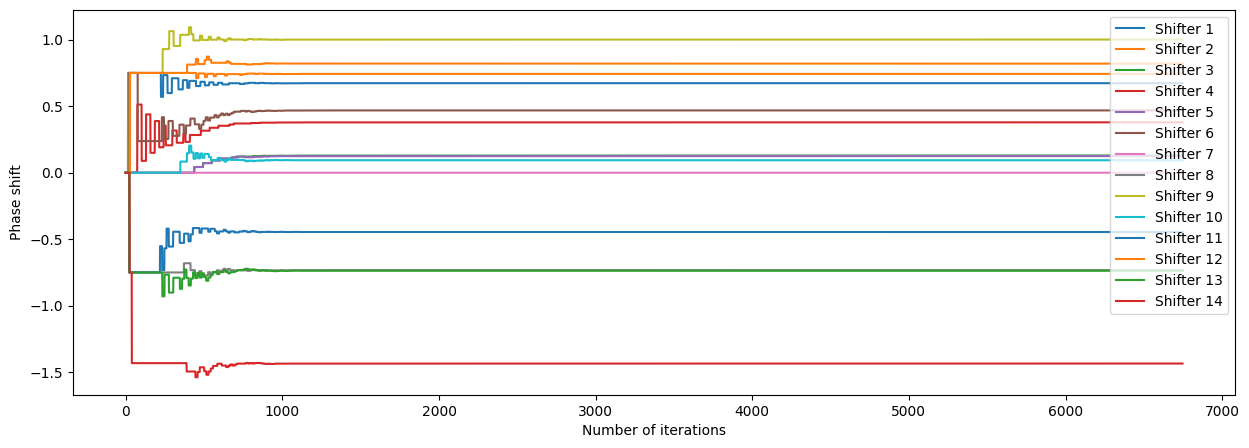

<class 'astropy.units.quantity.Quantity'>
Optimized parameters | Introduced error | Difference
P1 = 0.67 um | 0.10 um | 0.58 um
P2 = 0.74 um | 0.03 um | 0.72 um
P3 = 0.13 um | 0.13 um | 0.00 um
P4 = 0.38 um | 1.53 um | -1.15 um
P5 = 0.13 um | 1.17 um | -1.04 um
P6 = 0.47 um | 0.02 um | 0.45 um
P7 = 0.00 um | 0.16 um | -0.16 um
P8 = 0.92 um | 0.08 um | 0.84 um
P9 = 1.00 um | 0.04 um | 0.96 um
P10 = 0.09 um | 0.05 um | 0.04 um
P11 = 1.20 um | 1.47 um | -0.26 um
P12 = 0.82 um | 0.19 um | 0.63 um
P13 = 0.91 um | 0.04 um | 0.87 um
P14 = 0.22 um | 1.62 um | -1.41 um


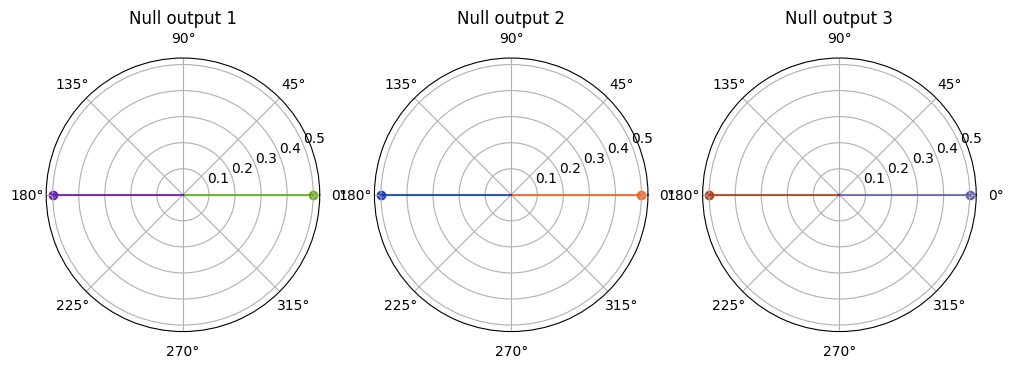

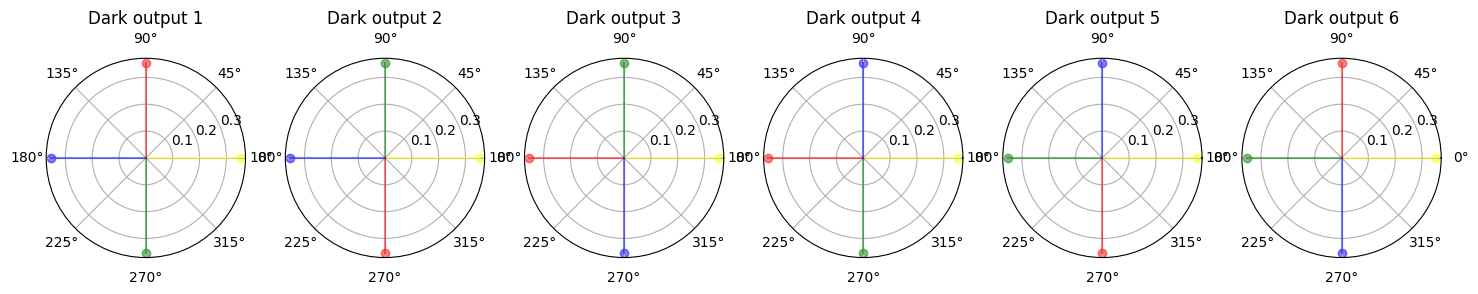

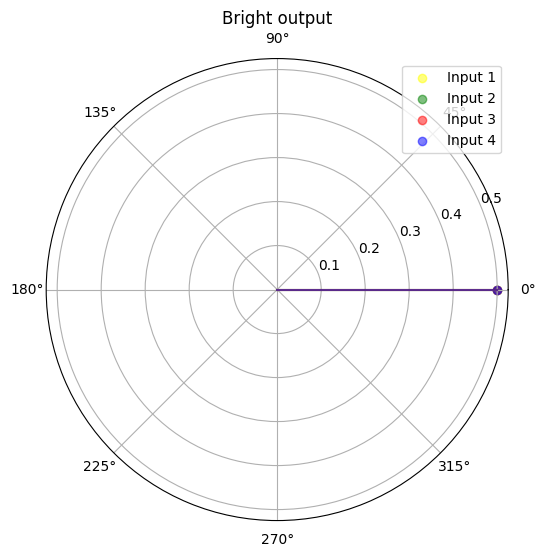

In [23]:
bright_evol, dark_symmetry_evol, shifts_evol = history["bright"], history["symmetry"], history["shifters"]

plt.figure(figsize=(15, 5))
# plt.axvline(bright_evol.shape[0], color='k', linestyle='--', linewidth=1, alpha=0.5)
plt.plot(bright_evol)
# plt.xlim(0, bright_evol.shape[0] + dark_symmetry_evol.shape[0])
plt.xlabel("Number of iterations")
plt.ylabel("Mean Null Depth")
plt.yscale("log")
plt.show()

plt.figure(figsize=(15, 5))
# plt.axvline(bright_evol.shape[0], color='k', linestyle='--', linewidth=1, alpha=0.5)
plt.plot(dark_symmetry_evol)
# plt.xlim(0, bright_evol.shape[0] + dark_symmetry_evol.shape[0])
plt.xlabel("Number of iterations")
plt.ylabel("Dark pairs difference")
plt.yscale("log")
plt.show()

plt.figure(figsize=(15, 5))
# plt.axvline(bright_evol.shape[0], color='k', linestyle='--', linewidth=1, alpha=0.5)
for i in range(shifts_evol.shape[1]):
    plt.plot(shifts_evol[:,i], label=f"Shifter {i+1}")
# plt.xlim(0, bright_evol.shape[0] + dark_symmetry_evol.shape[0])
plt.xlabel("Number of iterations")
plt.ylabel("Phase shift")
plt.yscale("linear")
plt.legend(loc='upper right')
plt.show()

print(type(optimized_shifts))

optimized_shifts = bound_OPD(optimized_shifts.value, L.value) * L.unit
print("Optimized parameters | Introduced error | Difference")
for i in range(14):
    op = optimized_shifts[i]
    ie = SHIFTS_TOTAL_OPD[i]
    diff = op - ie
    print(f"P{i+1} = {op:.2f} | {ie:.2f} | {diff:.2f}")

# Cheat code :
# optimized_parameters = -introduced_error

plot_kn_phase_effect(optimized_shifts)

# 🧐 Does it always work?

In [24]:
def optimization_emprical_proof():

    _, axs = plt.subplots(2, 7, figsize=(20, 5))
    axs = axs.flatten()

    _, axs2 = plt.subplots(2, 7, figsize=(20, 5))
    axs2 = axs2.flatten()

    for _ in range(100):
        shifts_total_OPD = np.array(np.random.uniform(0, L.value, 14))
        optimized_shifts, _ = optimize(kn, STAR_SIGNALS, shifts_total_OPD, L.value, INPUT_OPD_RMS.value)

        E = bound_OPD(shifts_total_OPD, L.value)
        P = bound_OPD(optimized_shifts, L.value)

        for i in range(14):
            axs[i].scatter(E[i], P[i], color='blue', s=1)
            axs[i].set_xlabel("Introduced error")
            axs[i].set_ylabel("Optimized shift")
            axs[i].set_title(f"P{i+1}")

        def bound(p):
            return bound_OPD(p, L.value)

        axs2[0].scatter(bound(E[0] - E[1]), bound(P[0] - P[1]), color='blue', s=1)
        axs2[0].set_title("P1-P2")
        axs2[1].scatter(bound(E[2] - E[3]), bound(P[2] - P[3]), color='blue', s=1)
        axs2[1].set_title("P3-P4")
        axs2[2].scatter(bound(E[4] - E[6]), bound(P[4] - P[6]), color='blue', s=1)
        axs2[2].set_title("P5 - P7")
        axs2[3].scatter(bound(E[5] - E[7]), bound(P[5] - P[7]), color='blue', s=1)
        axs2[3].set_title("P6 - P8")
        axs2[4].scatter(bound(E[8] - E[10]), bound(P[8] - P[10]), color='blue', s=1)
        axs2[4].set_title("P9 - P11")
        axs2[5].scatter(bound(E[9] - E[12]), bound(P[9] - P[12]), color='blue', s=1)
        axs2[5].set_title("P10 - P13")
        axs2[6].scatter(bound(E[11] - E[13]), bound(P[11] - P[13]), color='blue', s=1)
        axs2[6].set_title("P12 - P14")

        axs2[7].scatter(bound((E[0] + E[1]) - (E[2] + E[3])), bound((P[0] + P[1]) - (P[2] + P[3])), color='blue', s=1)
        axs2[7].set_title("(P1-P2)*P5 - (P3-P4)*P7")

        axs2[8].scatter((E[0] + E[1])/2 * E[4] - ((E[2] + E[3])/2 * E[6]), ((P[0] + P[1])/2 * P[4]) - ((P[2] + P[3])/2 * P[6]), color='blue', s=1)
        axs2[8].set_title("(P1+P2)/2*P5 - (P3+P4)/2*P7")

        for i in range(14):
            axs2[i].set_xlabel("Introduced error")
            axs2[i].set_ylabel("Optimized shift")

    plt.show()

# optimization_emprical_proof()

# 🎭 Shifters correlation

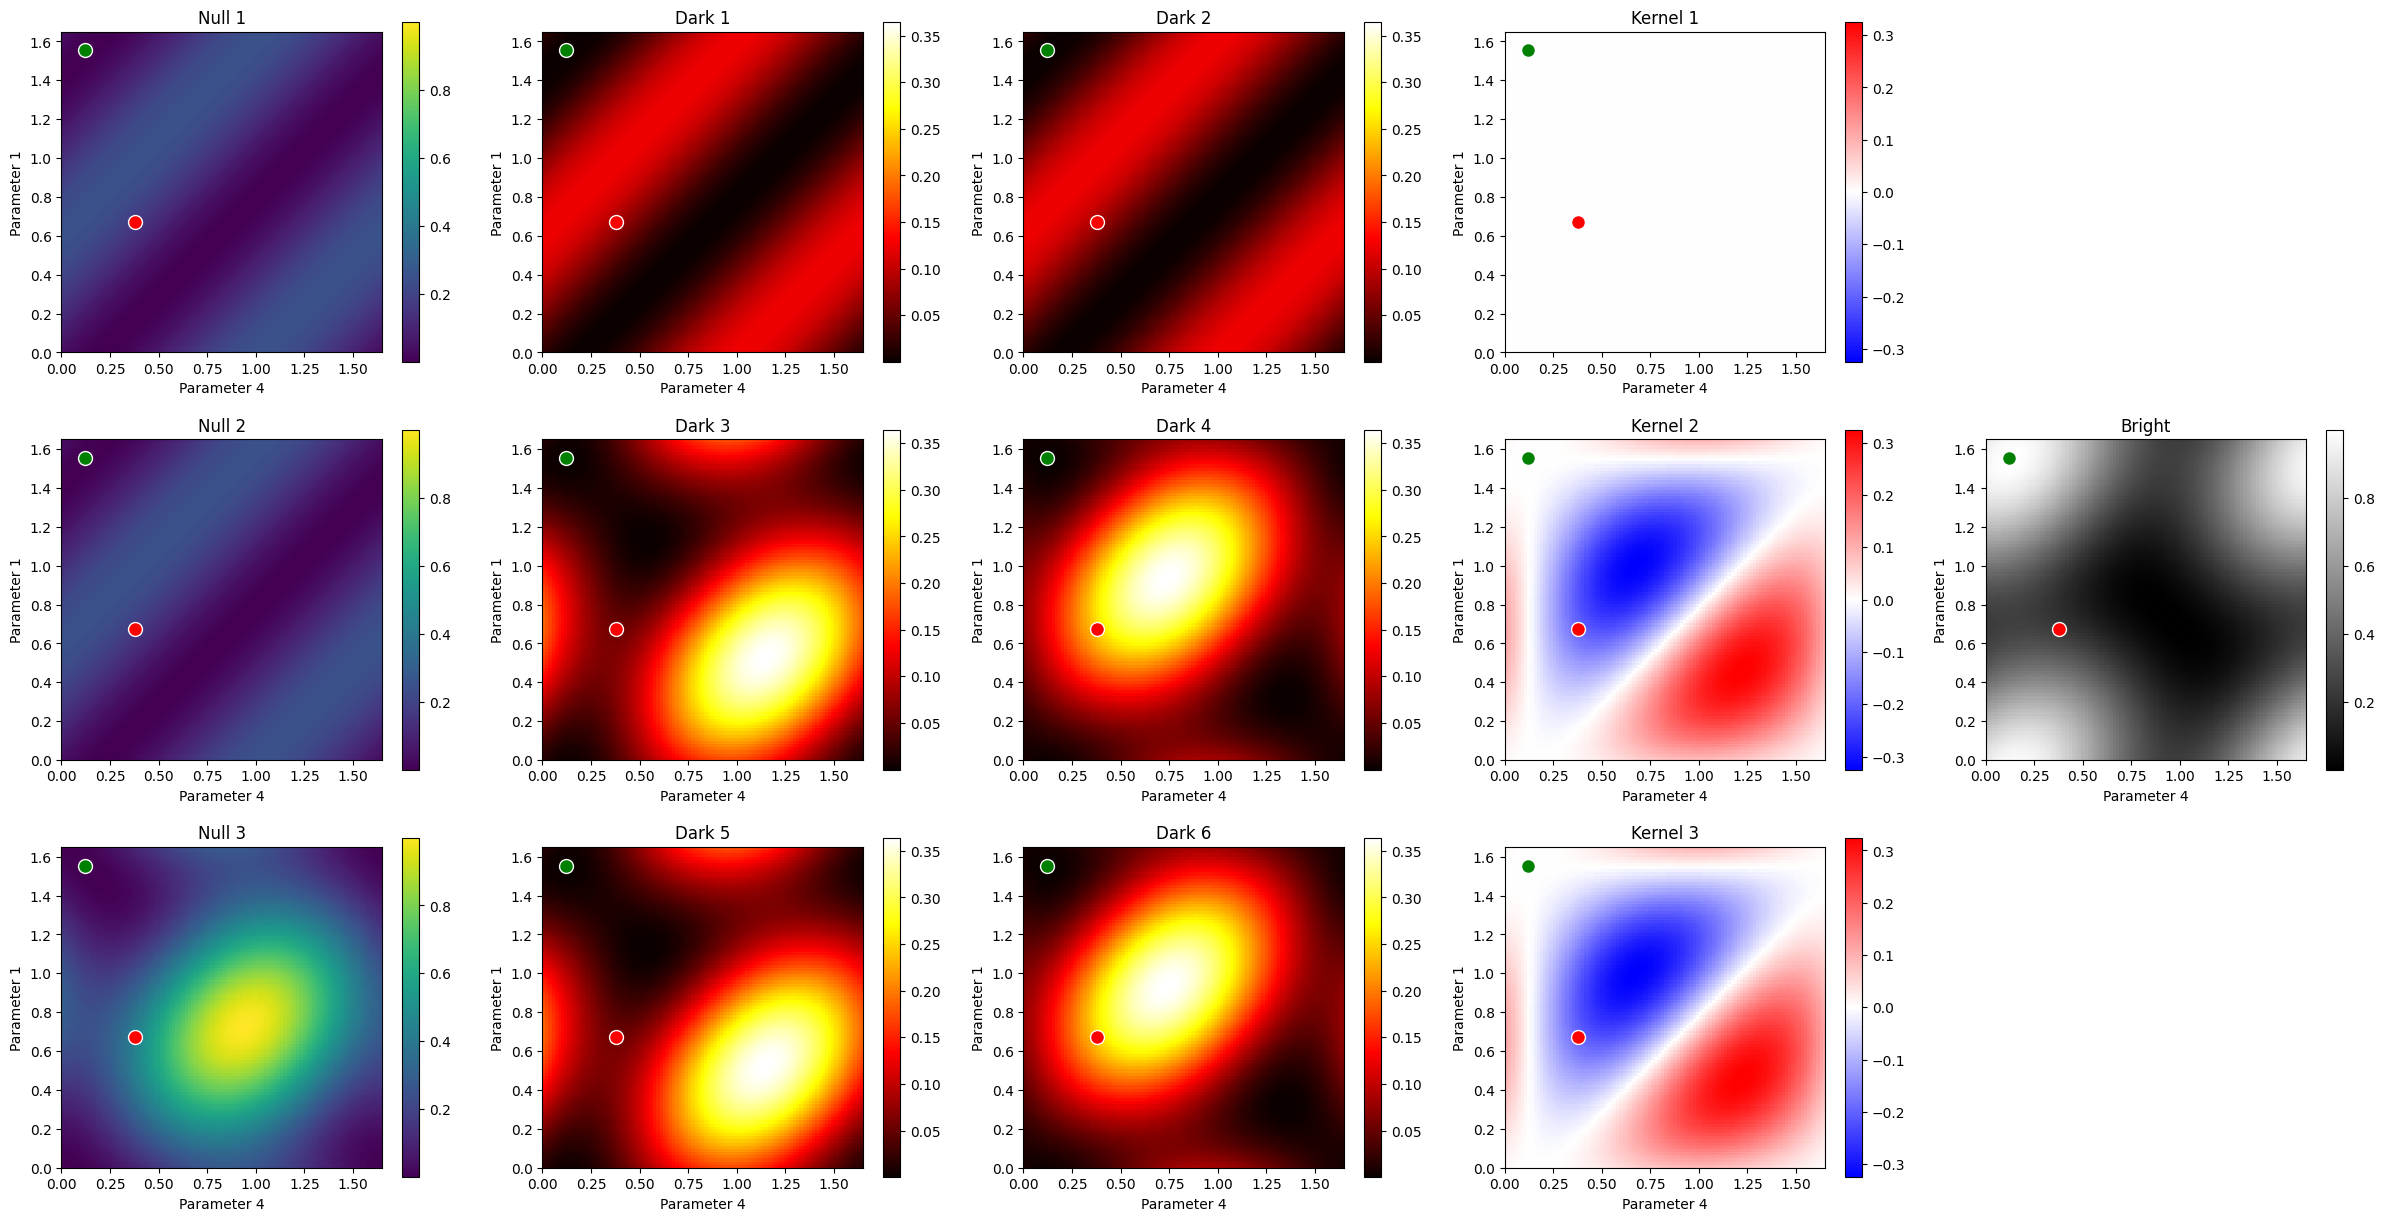

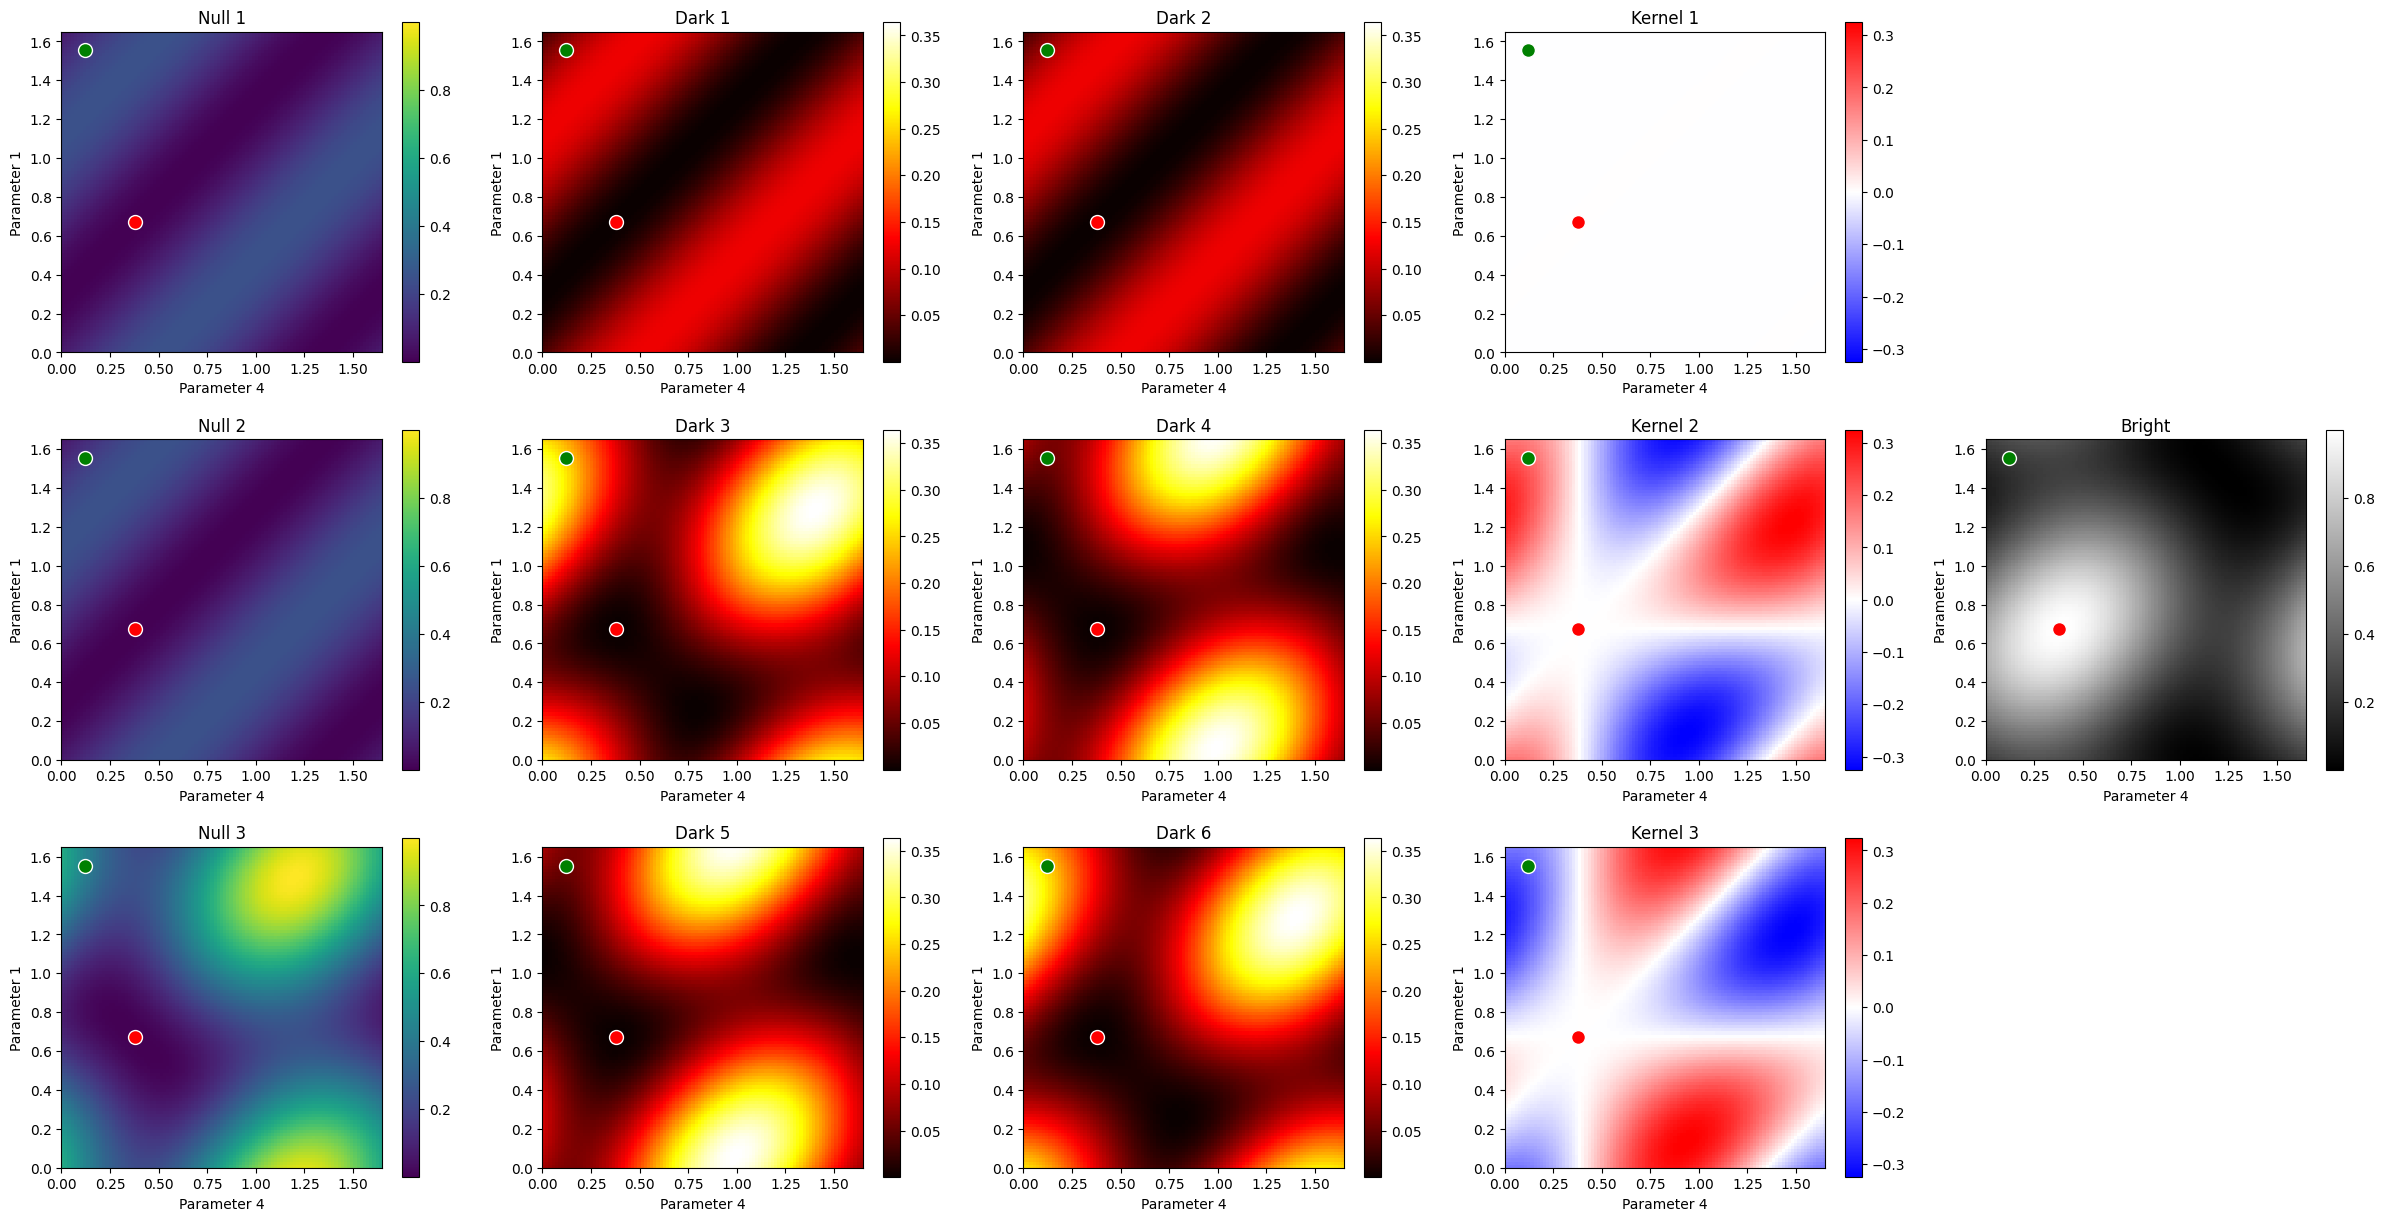

Optimized parameters
P1 = 0.67 um, ideal: 1.55 um
P2 = 0.74 um, ideal: 1.62 um
P3 = 0.13 um, ideal: 1.52 um
P4 = 0.38 um, ideal: 0.12 um
P5 = 0.13 um, ideal: 0.48 um
P6 = 0.47 um, ideal: 1.63 um
P7 = 0.00 um, ideal: 1.49 um
P8 = 0.92 um, ideal: 1.57 um
P9 = 1.00 um, ideal: 1.61 um
P10 = 0.09 um, ideal: 1.60 um
P11 = 1.20 um, ideal: 0.18 um
P12 = 0.82 um, ideal: 1.46 um
P13 = 0.91 um, ideal: 1.61 um
P14 = 0.22 um, ideal: 0.03 um


In [25]:
def scan(beams, scan_on, optimized_shifts = None, restricted=False):
    """------------------------------------------------------------------------
    Scan the parameter space and plot the null depths for each parameter
    combination.
    
    Parameters
    ----------
    kn : An instance of the KernelNuller class.
    beams : A list of 2D arrays, each representing a beam.
    optimized_parameters : A list of 14 floats, the optimized parameters.

    Returns
    -------
    None
    ------------------------------------------------------------------------"""

    # Scan shift power parameter space
    scan = np.linspace(0, L.value, 101, endpoint=True)
    nulls_map = np.zeros((3, len(scan), len(scan)))
    darks_map = np.zeros((6, len(scan), len(scan)))
    kernels_map = np.zeros((3, len(scan), len(scan)))
    bright_map = np.zeros((len(scan), len(scan)))

    _, axs = plt.subplots(3,5, figsize=(30,15))

    if restricted:
        # Consider only errors & correction on the shifter that are being scanned
        shifts = np.zeros(14)
        shifts_opd = np.zeros(14)
        shifts_opd[scan_on[0]-1] = SHIFTS_TOTAL_OPD[scan_on[0]-1].value
        shifts_opd[scan_on[1]-1] = SHIFTS_TOTAL_OPD[scan_on[1]-1].value

    else:
        # Consider all shifter errors & corrections
        shifts = optimized_shifts.copy()
        shifts_opd = SHIFTS_TOTAL_OPD.copy()

    for i, scan1 in enumerate(scan):
        for j, scan2 in enumerate(scan):
            shifts[scan_on[0]-1] = scan1
            shifts[scan_on[1]-1] = scan2

            nulls, darks, kernels, bright = kn(beams, shifts, shifts_opd, L.value)

            for k, null in enumerate(nulls):
                nulls_map[k,i,j] = np.abs(null)**2
            for k, dark in enumerate(darks):
                darks_map[k,i,j] = np.abs(dark)**2
            for k, kernel in enumerate(kernels):
                kernels_map[k,i,j] = kernel
            bright_map[i,j] = np.abs(bright)**2

    for k in range(3):
        p = axs[k, 0]
        p.set_title(f"Null {k+1}")
        im = p.imshow(nulls_map[k], extent=[0, L.value, 0, L.value], vmin=np.min(nulls_map), vmax=np.max(nulls_map))
        if optimized_shifts is not None:
            p.scatter(optimized_shifts[scan_on[1]-1], optimized_shifts[scan_on[0]-1], color='red', edgecolors='white', s=100)
            p.scatter(IDEAL_SHIFTS[scan_on[1]-1], IDEAL_SHIFTS[scan_on[0]-1], color='green', edgecolors='white', s=100)
        p.set_xlabel(f"Parameter {scan_on[1]}")
        p.set_ylabel(f"Parameter {scan_on[0]}")
        plt.colorbar(im)

    for k in range(6):
        p = axs[k//2, k%2+1]
        p.set_title(f"Dark {k+1}")
        im = p.imshow(darks_map[k], extent=[0, L.value, 0, L.value], vmin=np.min(darks_map), vmax=np.max(darks_map), cmap='hot')
        if optimized_shifts is not None:
            p.scatter(optimized_shifts[scan_on[1]-1], optimized_shifts[scan_on[0]-1], color='red', edgecolors='white', s=100)
            p.scatter(IDEAL_SHIFTS[scan_on[1]-1], IDEAL_SHIFTS[scan_on[0]-1], color='green', edgecolors='white', s=100)
        p.set_xlabel(f"Parameter {scan_on[1]}")
        p.set_ylabel(f"Parameter {scan_on[0]}")
        plt.colorbar(im)

    for k in range(3):
        p = axs[k, 3]
        p.set_title(f"Kernel {k+1}")
        im = p.imshow(kernels_map[k], extent=[0, L.value, 0, L.value], vmin=np.min(kernels_map), vmax=np.max(kernels_map), cmap='bwr')
        if optimized_shifts is not None:
            p.scatter(optimized_shifts[scan_on[1]-1], optimized_shifts[scan_on[0]-1], color='red', edgecolors='white', s=100)
            p.scatter(IDEAL_SHIFTS[scan_on[1]-1], IDEAL_SHIFTS[scan_on[0]-1], color='green', edgecolors='white', s=100)
        p.set_xlabel(f"Parameter {scan_on[1]}")
        p.set_ylabel(f"Parameter {scan_on[0]}")
        plt.colorbar(im)

    p = axs[1,4]
    p.set_title(f"Bright")
    im = p.imshow(bright_map, extent=[0, L.value, 0, L.value], cmap='gray')
    if optimized_shifts is not None:
        p.scatter(optimized_shifts[scan_on[1]-1], optimized_shifts[scan_on[0]-1], color='red', edgecolors='white', s=100)
        p.scatter(IDEAL_SHIFTS[scan_on[1]-1], IDEAL_SHIFTS[scan_on[0]-1], color='green', edgecolors='white', s=100)
    p.set_xlabel(f"Parameter {scan_on[1]}")
    p.set_ylabel(f"Parameter {scan_on[0]}")
    plt.colorbar(im)

    axs[0, 4].axis('off')
    axs[2, 4].axis('off')
    
    plt.show()

scan_on=(1,4)
scan(beams=STAR_SIGNALS,scan_on=scan_on,optimized_shifts=OPTIMIZED_SHIFTS.value,restricted=True)
scan(beams=STAR_SIGNALS,scan_on=scan_on,optimized_shifts=OPTIMIZED_SHIFTS.value,restricted=False)

print("Optimized parameters")
for i in range(14):
    print(f"P{i+1} = {OPTIMIZED_SHIFTS[i]:.2f}, ideal: {IDEAL_SHIFTS[i]:.2f}")

# 📊 Simulation & analysis

In [26]:
@nb.njit()
def bulk_observation_jitted(
        N:int, # Number of observations
        star_signals:np.array, # Star signals
        planet_signals:np.array, # Planet signals
        shifts:np.array, # Shifts to apply
        shifts_total_opd:np.array, # Shifts error
        input_opd_rms:float, # Input OPD RMS
        wavelength:float # Wavelength
    ):

    nulls_dist_so = np.empty((3,N))
    nulls_dist_wp = np.empty((3,N))
    darks_dist_so = np.empty((6,N))
    darks_dist_wp = np.empty((6,N))
    kernels_dist_so = np.empty((3,N))
    kernels_dist_wp =  np.empty((3,N))
    kernels_dist_so = np.empty((3,N))
    kernels_dist_wp =  np.empty((3,N))
    cumul_dist_so = np.empty(N)
    cumul_dist_wp = np.empty(N)

    for i in range(N):
        noise = random_normal(input_opd_rms, 4)
        noised_star_signals = phase_shift(star_signals, noise, wavelength)

        # Star only ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        nulls_so, darks_so, kernels_so, bright_so = kn(noised_star_signals, shifts, shifts_total_opd, wavelength)

        nulls_int_so = np.abs(nulls_so)**2
        for j in range(3):
            nulls_dist_so[j,i]  = nulls_int_so[j]
        
        darks_int_so = np.abs(darks_so)**2
        for j in range(6):
            darks_dist_so[j,i] = darks_int_so[j]

        for j in range(3):
            kernels_dist_so[j,i] = kernels_so[j]

        cumul_dist_so[i] = np.abs(kernels_so[0]) + np.abs(kernels_so[1]) + np.abs(kernels_so[2])

        # With planet ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        noised_planet_signals = phase_shift(planet_signals, noise, wavelength)
        nulls_wp, darks_wp, kernels_wp, bright_wp = kn(planet_signals, shifts, shifts_total_opd, wavelength)

        nulls_int_wp = np.abs(nulls_wp)**2 + nulls_int_so
        for j in range(3):
            nulls_dist_wp[j,i] = nulls_int_wp[j]

        darks_int_wp = np.abs(darks_wp)**2 + darks_int_so
        for j in range(6):
            darks_dist_wp[j,i] = darks_int_wp[j]

        for j in range(3):
            kernels_dist_wp[j,i] = kernels_wp[j] + kernels_so[j]

        cumul_dist_wp[i] = np.abs(kernels_wp[0] + kernels_so[0]) + np.abs(kernels_wp[1] + kernels_so[1]) + np.abs(kernels_wp[2] + kernels_so[2])

    return (
        nulls_dist_so,
        nulls_dist_wp,
        darks_dist_so,
        darks_dist_wp,
        kernels_dist_so,
        kernels_dist_wp,
        cumul_dist_so,
        cumul_dist_wp
    )

# User-friendly interface (Numba can't manage dicts with unconsistent data)
def bulk_observation(N, star_signals, planet_signals, shifts, shifts_total_opd, input_opd_rms, wavelegth):
    bulk_list = bulk_observation_jitted(N, star_signals, planet_signals, shifts, shifts_total_opd, input_opd_rms, wavelegth)
    return {
        "nulls_so":bulk_list[0],
        "nulls_wp":bulk_list[1],
        "darks_so":bulk_list[2],
        "darks_wp":bulk_list[3],
        "kernels_so":bulk_list[4],
        "kernels_wp":bulk_list[5],
        "cumul_so":bulk_list[6],
        "cumul_wp":bulk_list[7]
    }

dists = bulk_observation(10000, STAR_SIGNALS, PLANET_SIGNALS, optimized_shifts.value, SHIFTS_TOTAL_OPD.value, INPUT_OPD_RMS.value, L.value)

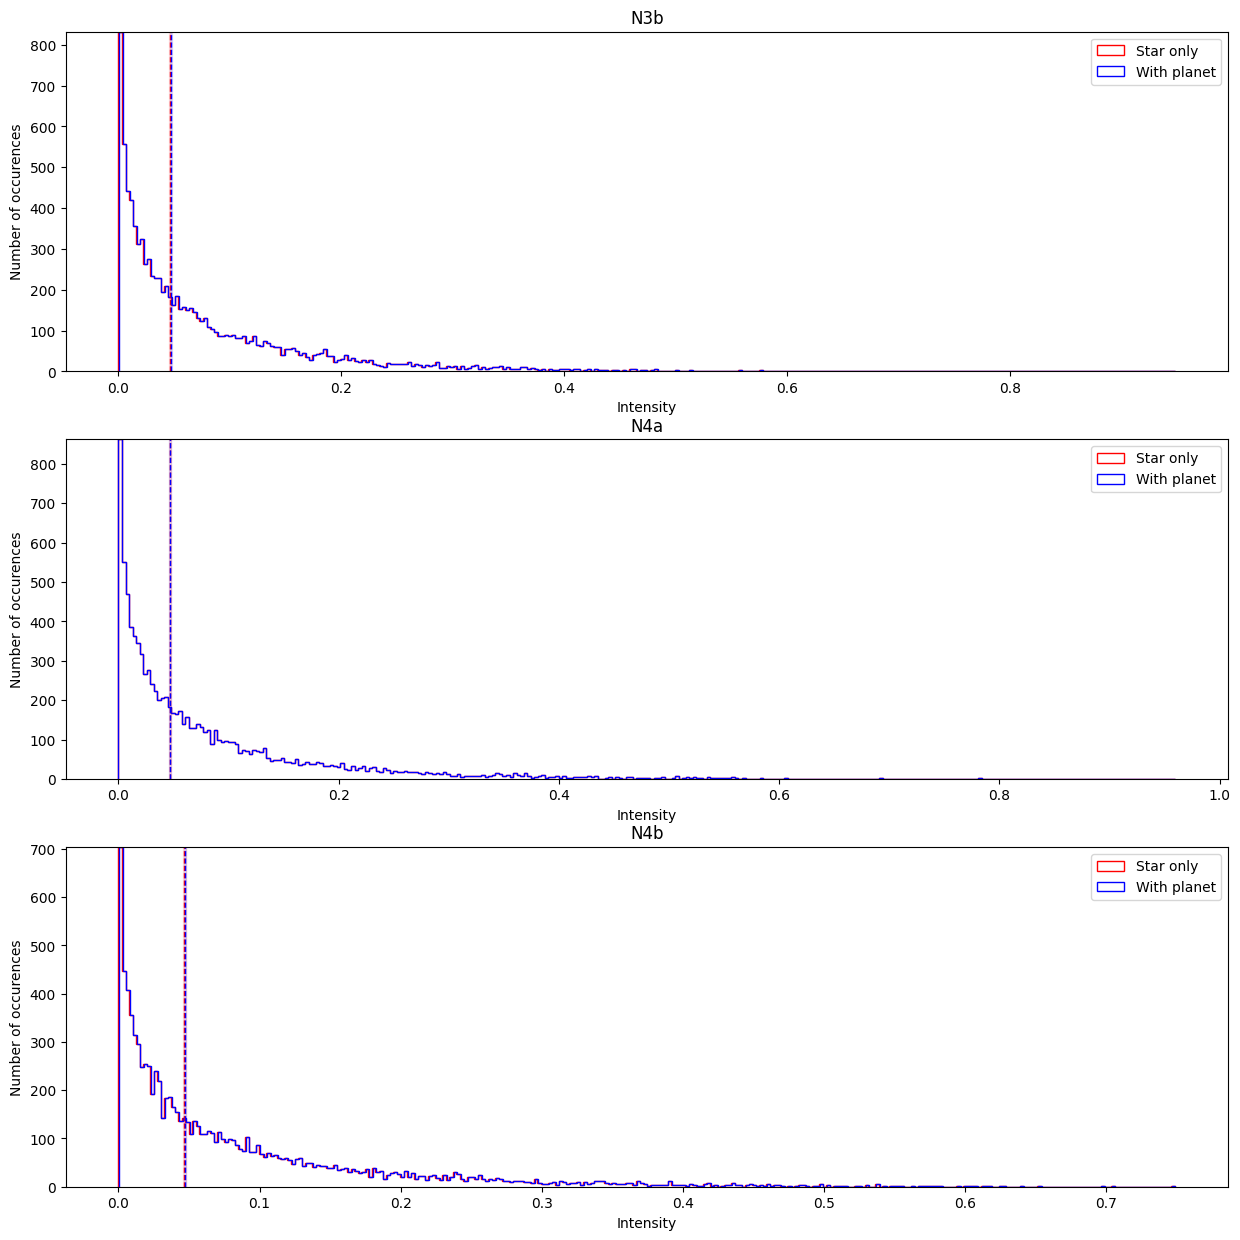

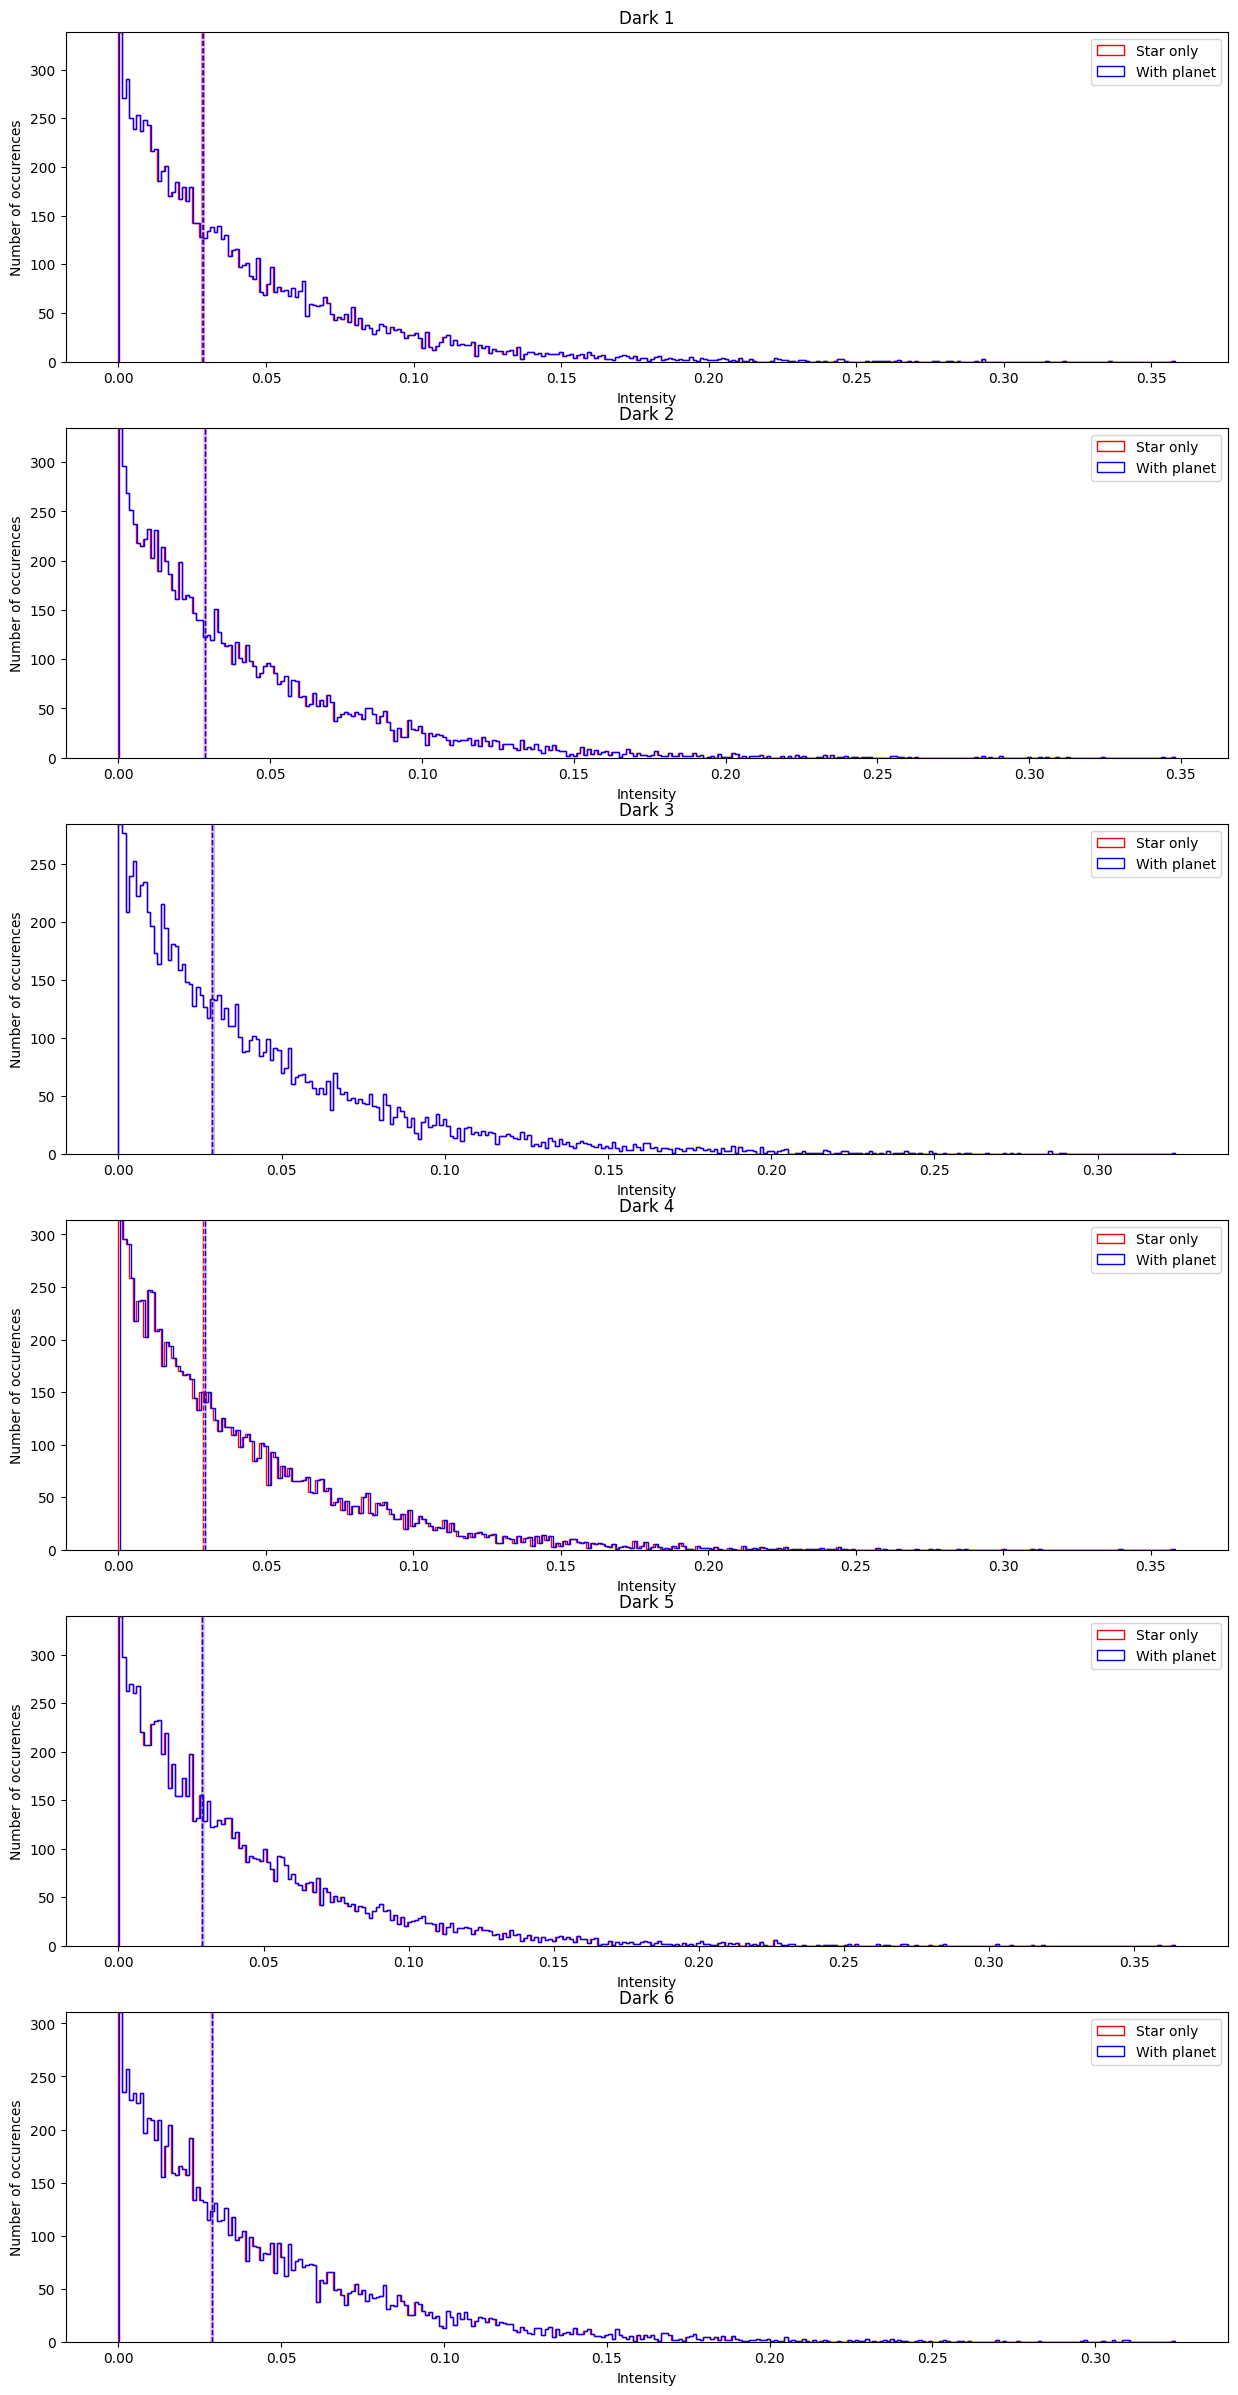

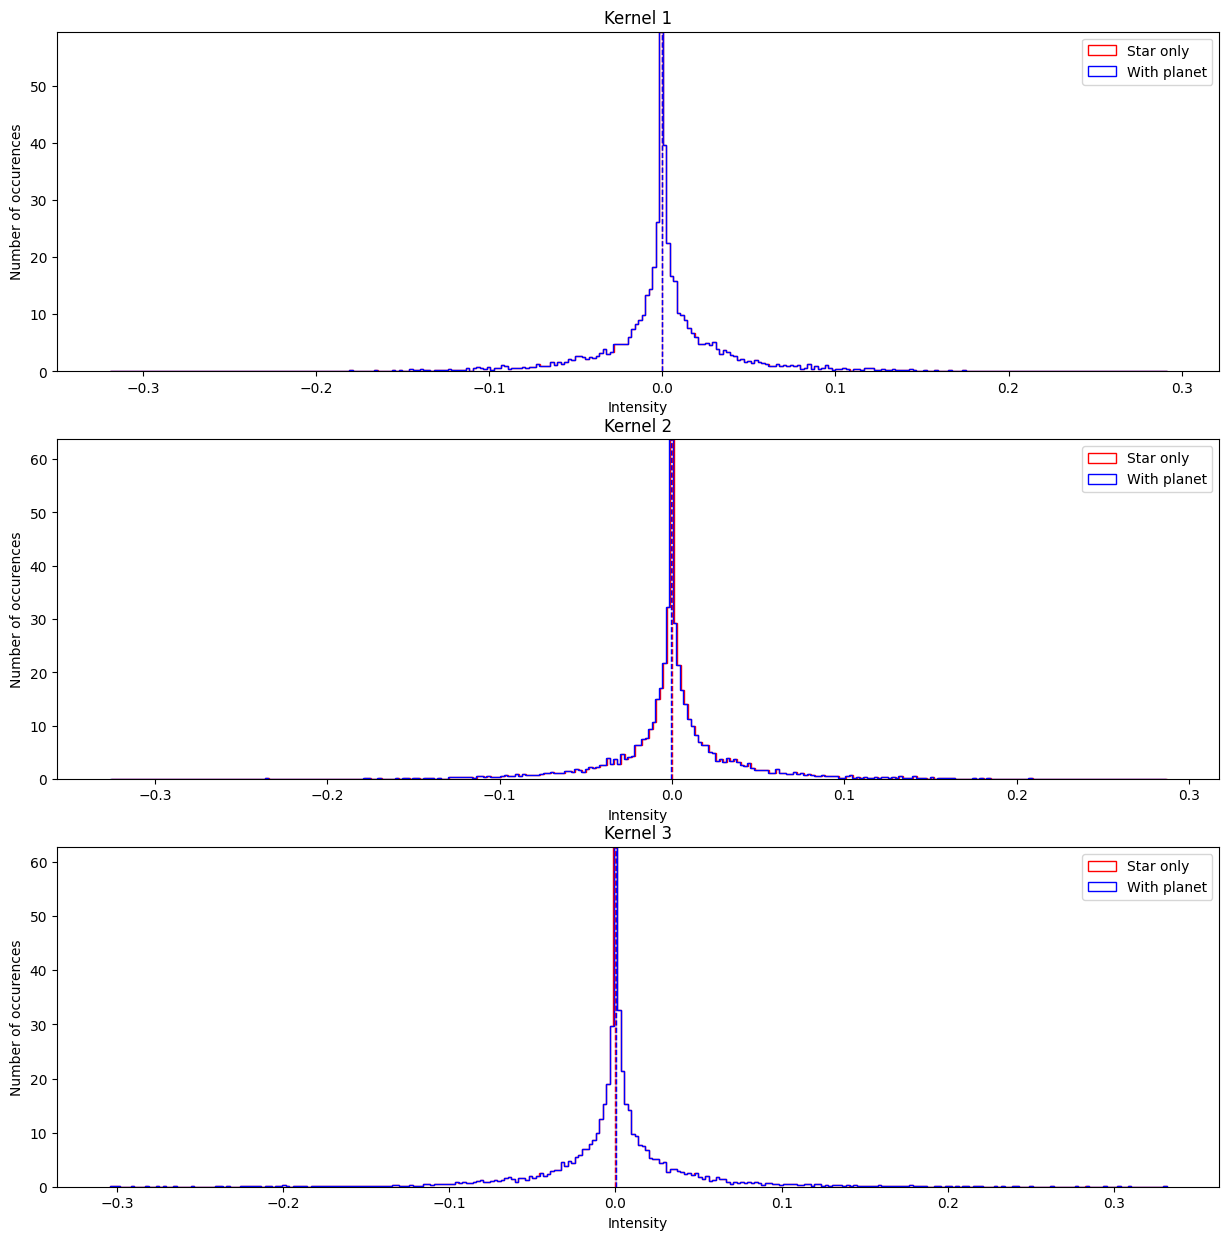

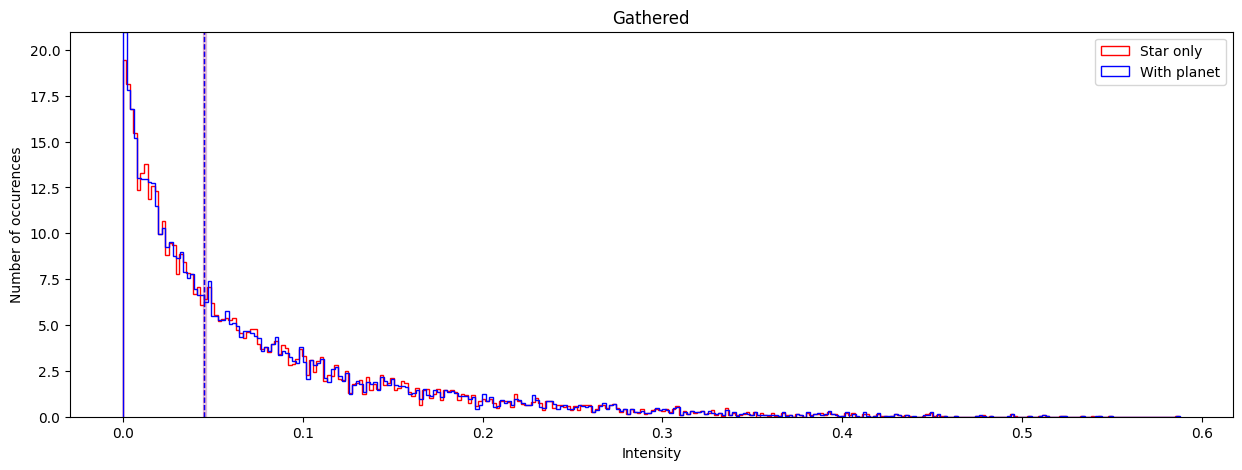

In [27]:
# Analysis --------------------------------------------------------------------

null_outputs = ['N3b', 'N4a', 'N4b']

# Estimation ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

estimator = np.median

mean_null_star_only =  [[],[],[]]
mean_null_with_planet =  [[],[],[]]
for j in range(3):
    mean_null_star_only[j] = estimator(dists['nulls_so'][j])
    mean_null_with_planet[j] = estimator(dists['nulls_wp'][j])

mean_dark_star_only =  [[],[],[],[],[],[]]
mean_dark_with_planet =  [[],[],[],[],[],[]]
for j in range(6):
    mean_dark_star_only[j] = estimator(dists['darks_so'][j])
    mean_dark_with_planet[j] = estimator(dists['darks_wp'][j])

mean_kernel_star_only =  [[],[],[]]
mean_kernel_with_planet =  [[],[],[]]
for j in range(3):
    mean_kernel_star_only[j] = estimator(dists['kernels_so'][j])
    mean_kernel_with_planet[j] = estimator(dists['kernels_wp'][j])

mean_cumul_so = estimator(dists['cumul_so'])
mean_cumul_wp = estimator(dists['cumul_wp'])

# Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def bootstrap(data, N=1000, estimator=np.median):
    return np.std([estimator(np.array(data)[np.random.randint(0, len(data), size=len(data))]) for _ in range(N)])

std_null_star_only =  [[],[],[],[],[]]
std_null_with_planet =  [[],[],[],[],[]]
for j in range(3):
    std_null_star_only[j] = bootstrap(dists['nulls_so'][j])
    std_null_with_planet[j] = bootstrap(dists['nulls_wp'][j])

std_dark_star_only =  [[],[],[],[],[],[]]
std_dark_with_planet =  [[],[],[],[],[],[]]
for j in range(6):
    std_dark_star_only[j] = bootstrap(dists['darks_so'][j])
    std_dark_with_planet[j] = bootstrap(dists['darks_wp'][j])

std_kernel_star_only =  [[],[],[]]
std_kernel_with_planet =  [[],[],[]]
for j in range(3):
    std_kernel_star_only[j] = bootstrap(dists['kernels_so'][j])
    std_kernel_with_planet[j] = bootstrap(dists['kernels_wp'][j])

std_cumul_so = bootstrap(dists['cumul_so'])
std_cumul_wp = bootstrap(dists['cumul_wp'])

# Plots -----------------------------------------------------------------------

bins = 300

# Nuller ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(3, 1, figsize=(15, 15))
for i in range(3):
    ax = axs[i]

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(dists['nulls_so'][i], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1)
    n2,_,_ = ax.hist(np.array(dists['nulls_wp'][i]), bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1)
    m = max(max(n1), max(n2))
    ax.set_ylim(0, m)

    # Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_null_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_null_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot std as filled area
    ax.fill_betweenx([0, m], mean_null_star_only[i]-std_null_star_only[i], mean_null_star_only[i]+std_null_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, m], mean_null_with_planet[i]-std_null_with_planet[i], mean_null_with_planet[i]+std_null_with_planet[i], color='blue', alpha=0.1)

    ax.set_title(f"{null_outputs[i]}")
    ax.legend()

# Dark ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
fig, axs = plt.subplots(6, 1, figsize=(15, 30))
for i in range(6):
    ax = axs[i]

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(dists['darks_so'][i], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1)
    n2,_,_ = ax.hist(np.array(dists['darks_wp'][i]), bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1)
    m = max(max(n1), max(n2))
    ax.set_ylim(0, m)

    # Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_dark_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_dark_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot std as filled area
    ax.fill_betweenx([0, m], mean_dark_star_only[i]-std_dark_star_only[i], mean_dark_star_only[i]+std_dark_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, m], mean_dark_with_planet[i]-std_dark_with_planet[i], mean_dark_with_planet[i]+std_dark_with_planet[i], color='blue', alpha=0.1)

    ax.set_title(f"Dark {i+1}")
    ax.legend()

# Kernel ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(3, 1, figsize=(15, 15))
for i in range(3):
    ax = axs[i]

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(dists['kernels_so'][i], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1, density=True)
    n2,_,_ = ax.hist(np.array(dists['kernels_wp'][i]), bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1, density=True)
    m = max(max(n1), max(n2))
    ax.set_ylim(0, m)

    # Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_kernel_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_kernel_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot std as filled area
    ax.fill_betweenx([0, m], mean_kernel_star_only[i]-std_kernel_star_only[i], mean_kernel_star_only[i]+std_kernel_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, m], mean_kernel_with_planet[i]-std_kernel_with_planet[i], mean_kernel_with_planet[i]+std_kernel_with_planet[i], color='blue', alpha=0.1)

    # ax.set_yscale("log")
    ax.set_title(f"Kernel {i+1}")
    ax.legend()

# Gathered ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

n1,_,_ = ax.hist(dists['cumul_so'], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1, density=True)
n2,_,_ = ax.hist(dists['cumul_wp'], bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1, density=True)
m = max(max(n1), max(n2))
ax.set_ylim(0, m)

# Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax.set_xlabel("Intensity")
ax.set_ylabel("Number of occurences")
ax.axvline(mean_cumul_so, color='red', linestyle='dashed', linewidth=1)
ax.axvline(mean_cumul_wp, color='blue', linestyle='dashed', linewidth=1)

# Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Plot std as filled area
ax.fill_betweenx([0, m], mean_cumul_so-std_cumul_so, mean_cumul_so+std_cumul_so, color='red', alpha=0.1)
ax.fill_betweenx([0, m], mean_cumul_wp-std_cumul_wp, mean_cumul_wp+std_cumul_wp, color='blue', alpha=0.1)

ax.set_title(f"Gathered")
ax.legend()

plt.show()

# 📢 Noise sensitivity

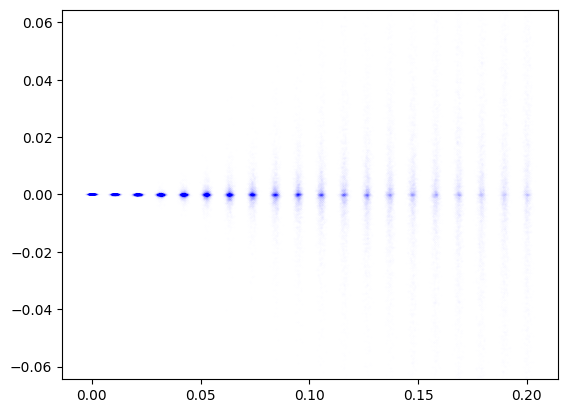

In [28]:
def plot_sensitivity_to_noise(shifts):

    input_opd_rms_range = np.linspace(0, 200, 20) * u.nm
    input_opd_rms_range = input_opd_rms_range.to(L.unit)

    line_width = 0.001*(1*input_opd_rms_range.unit).to(L.unit).value

    means = []
    stds = []

    kernel_dists = []

    for input_opd_rms in input_opd_rms_range:

        dists = bulk_observation(1000, STAR_SIGNALS, np.zeros(4, dtype=np.complex128), np.zeros(14), np.zeros(14), input_opd_rms.value, L.value)

        kernel_dist = np.concatenate([*dists['kernels_so']])

        kernel_dists.append(kernel_dist)
            
        plt.scatter(np.random.normal(input_opd_rms.value, line_width, len(kernel_dist)), kernel_dist, color='blue', s=0.1, alpha=0.01)

        # plt.boxplot(kernel_dist, vert=True, patch_artist=True, positions=[input_opd_rms.value], showfliers=False, widths=line_width/5, boxprops=dict(facecolor='none', color='black'))

        means.append(np.mean(kernel_dist))
        stds.append(np.std(kernel_dist))

    k = np.array(kernel_dists)

    
    # plt.boxplot(k, vert=True, positions=[input_opd_rms_range.value], showfliers=False, widths=line_width)

    plt.ylim(-max(stds), max(stds))

plot_sensitivity_to_noise(optimized_shifts)

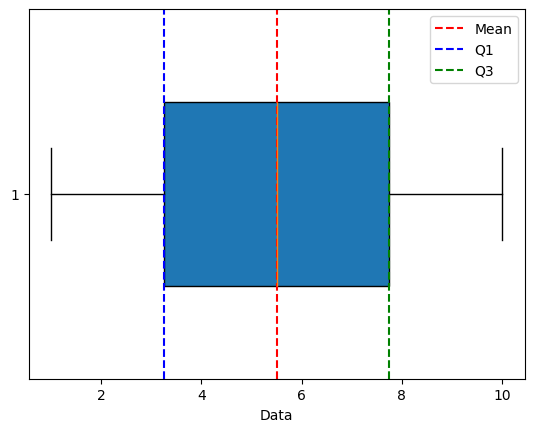

In [29]:
import numpy as np
import matplotlib.pyplot as plt
# Assuming you have a list of data points called 'data'
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Calculate the mean and quartiles
mean = np.mean(data)
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)

# Create the boxplot
plt.boxplot(data, vert=False, widths=0.5, patch_artist=True)

# Add the mean and quartiles as horizontal lines
plt.axvline(mean, color='red', linestyle='--', label='Mean')
plt.axvline(q1, color='blue', linestyle='--', label='Q1')
plt.axvline(q3, color='green', linestyle='--', label='Q3')

# Add legend and labels
plt.legend()
plt.xlabel('Data')
plt.ylabel('')

# Show the plot
plt.show()


# ❓ ROC tests

In [30]:
def argmax(data, resolution):
    hist = np.histogram(data, bins=resolution)
    return hist[1][np.argmax(hist[0])]
    # right_edge = hist[1][np.argmax(hist[0])+1]
    # return (left_edge + right_edge) / 2

estimators = {
    'Argmax100': lambda data: abs(argmax(data, 100)),
    'Argmax50': lambda data: abs(argmax(data, 50)),
    'Argmax500': lambda data: abs(argmax(data, 500)),
    'Mean': lambda data: abs(np.mean(data)),
    'Median': lambda data: abs(np.median(data)),
}
cmap = {
    "Argmax100":"blue",
    "Mean":"orange",
    "Median":"green",
    "Argmax50":"red",
    "Argmax500":"purple"
}

T0 = []
T1 = []
Nmc = 1000
size = 1000

# Sequential
@nb.njit()
def ROC(shifts, shifts_total_opd, input_opd_rms, wavelenght):
    T0 = np.zeros((Nmc,size))
    T1 = np.zeros((Nmc,size))
    for i in range(Nmc):
        dists = bulk_observation_jitted(size, STAR_SIGNALS, PLANET_SIGNALS, shifts, shifts_total_opd, input_opd_rms, wavelenght)
        T0[i] = dists[4][1]
        T1[i] = dists[5][1]
    return T0, T1
T0, T1 = ROC(optimized_shifts.value, SHIFTS_TOTAL_OPD.value, INPUT_OPD_RMS.value, L.value)

# # Parallel
# with concurrent.futures.ThreadPoolExecutor(20) as executor:
#     results = list(executor.map(
#         lambda x: bulk_observation(*x),
#         [(1000, star_signals, planet_signals, optimized_parameters)] * Nmc
#     ))
# T0 = np.array([r['kernels_so'][1] for r in results])
# T1 = np.array([r['kernels_wp'][1] for r in results])


0.00777036522025043


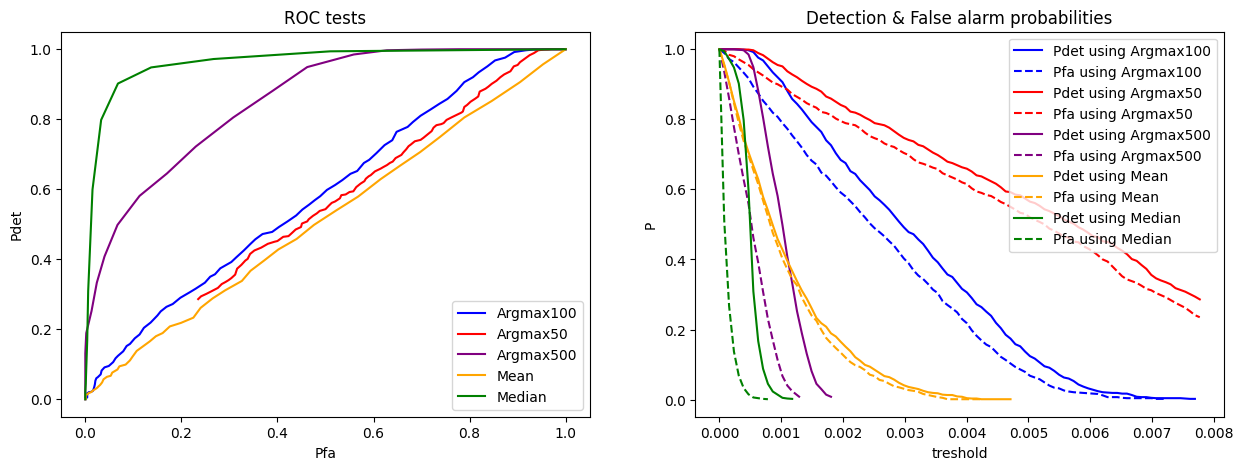

In [31]:
planet_intensity = np.sum(np.abs(PLANET_SIGNALS)**2)

max_estimator = max([
    np.max(np.abs(np.mean(T0, axis=1))),
    np.max(np.abs(np.mean(T1, axis=1))),
    np.max(np.abs(np.median(T0, axis=1))),
    np.max(np.abs(np.median(T1, axis=1))),
    np.max(np.abs(np.array([argmax(t, 100) for t in T0]))),
    np.max(np.abs(np.array([argmax(t, 100) for t in T1])))
])
thresholds = np.linspace(0, max_estimator, 100)
print(max_estimator)

_, axs = plt.subplots(1, 2, figsize=(15, 5))

for name, estimator in estimators.items():
    Pfa = np.zeros(len(thresholds))
    Pdet = np.zeros(len(thresholds))
    for i, threshold in enumerate(thresholds):
        Pfa[i] = np.sum(np.array([estimator(t) for t in T0]) > threshold) / Nmc
        Pdet[i] = np.sum(np.array([estimator(t) for t in T1]) > threshold) / Nmc

    # print(f"\n{name} :")
    # print(Pfa)
    # print(Pdet)

    axs[0].plot(Pfa, Pdet, label=name, color=cmap[name])

    # Trim Pfa and Pdet
    Pfa = Pfa[Pfa > 0]
    Pdet = Pdet[Pdet > 0]

    axs[1].plot(thresholds[:len(Pdet)], Pdet, c=cmap[name], label="Pdet using " + name)
    axs[1].plot(thresholds[:len(Pfa)], Pfa, c=cmap[name], label="Pfa using " + name, linestyle='--')

axs[0].set_xlabel("Pfa")
axs[0].set_ylabel("Pdet")
axs[0].set_title("ROC tests")
axs[0].legend()
axs[1].set_xlabel("treshold")
axs[1].set_ylabel("P")
axs[1].set_title("Detection & False alarm probabilities")
axs[1].legend()
plt.show()

# ☑️ Model fitting

2024-04-29 11:37:28.490 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=2525.254649)
2024-04-29 11:37:28.492 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=2386.824323)
2024-04-29 11:37:28.499 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2232.702605)
2024-04-29 11:37:28.510 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1259.901395)
2024-04-29 11:37:28.539 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=2377.755044)
2024-04-29 11:37:28.622 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=209.206392)
2024-04-29 11:37:28.806 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1811.204156)
2024-04-29 11:37:28.859 | INFO     | fitter.fitter:_fit_single_dis

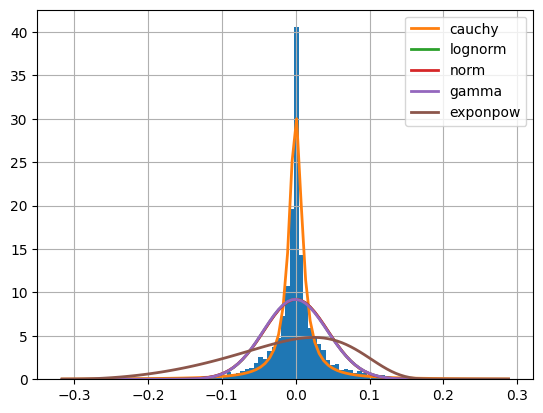

In [32]:
def fit(data):
    f = fitter.Fitter(data,
           distributions=fitter.get_common_distributions())
    f.fit()
    f.summary()

fit(dists['kernels_so'][0])